In [22]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import os
from scipy import stats
from sklearn.ensemble import IsolationForest

os.environ['OMP_NUM_THREADS'] = '1'

file_path = "Janitza Reading.xlsx"
janitza_data = pd.read_excel(file_path,engine='openpyxl')  # Load all sheets
print(janitza_data .iloc[:10, 5])



0    362627
1    103336
2    102709
3     13057
4     12093
5      1536
6     14070
7     36843
8     27265
9     25092
Name: 2022-04-01 00:00:00, dtype: object


In [24]:
import pandas as pd
import numpy as np

# Read the Excel file
df = pd.read_excel('Janitza Reading.xlsx', sheet_name='Janitza data', skiprows=0, nrows=72, usecols='B:AL')

# Rename columns
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = range(2022, 2025)
new_columns = ['Meter_location'] + [f'{month}_{year}' for year in years for month in months]
df.columns = new_columns
df_base = df

# Replace missing values and NULL with 0
df = df.fillna(0)

# Convert all columns except 'Meter_location' to numeric
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Perform seasonal imputation
for year in range(2022, 2024):
    for month in months:
        current_col = f'{month}_{year}'
        prev_year_col = f'{month}_{year-1}' if year > 2022 else None
        next_year_col = f'{month}_{year+1}'
        
        if prev_year_col:
            mask = (df[current_col] == 0) & ((df[prev_year_col] != 0) | (df[next_year_col] != 0))
            df.loc[mask, current_col] = df.loc[mask, [prev_year_col, next_year_col]].mean(axis=1)
        else:
            mask = (df[current_col] == 0) & (df[next_year_col] != 0)
            df.loc[mask, current_col] = df.loc[mask, next_year_col]

# Round off values to 2 decimal points
df.iloc[:, 1:] = df.iloc[:, 1:].round(2)

# Export cleaned data to CSV
df.to_csv('Jantiza_Med_Data_Cleaned.csv', index=False)

print("Data processing complete. Check the output file 'Jantiza_Med_Data_Cleaned.csv'.")


Data processing complete. Check the output file 'Jantiza_Med_Data_Cleaned.csv'.


C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\389344157.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1307.82]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, current_col] = df.loc[mask, next_year_col]
C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\389344157.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1487.83]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, current_col] = df.loc[mask, next_year_col]
C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\389344157.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[150.77]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  d

In [3]:
import pandas as pd
import numpy as np

def process_table(df, table_name):
    # Rename columns
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    years = range(2022, 2025)
    new_columns = ['Meter_location'] + [f'{month}_{year}' for year in years for month in months]
    df.columns = new_columns

    # Remove rows with null Meter_location
    df = df.dropna(subset=['Meter_location'])

    # Replace missing values and NULL with 0
    df = df.fillna(0)

    # Convert all columns except 'Meter_location' to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Perform seasonal imputation
    for year in range(2022, 2024):
        for month in months:
            current_col = f'{month}_{year}'
            prev_year_col = f'{month}_{year-1}' if year > 2022 else None
            next_year_col = f'{month}_{year+1}'
            
            if prev_year_col:
                mask = (df[current_col] == 0) & ((df[prev_year_col] != 0) | (df[next_year_col] != 0))
                df.loc[mask, current_col] = df.loc[mask, [prev_year_col, next_year_col]].mean(axis=1)
            else:
                mask = (df[current_col] == 0) & (df[next_year_col] != 0)
                df.loc[mask, current_col] = df.loc[mask, next_year_col]

    # Round off values to 2 decimal points
    df.iloc[:, 1:] = df.iloc[:, 1:].round(2)

    # Export cleaned data to CSV
    df.to_csv(f'{table_name}_Cleaned.csv', index=False)

    print(f"Data processing complete for {table_name}. Check the output file '{table_name}_Cleaned.csv'.")

    return df

# Read and process each table
file_path = 'Janitza Reading.xlsx'

tables = [
    {'name': 'Janitza_Med_Data', 'skiprows': 0, 'nrows': 72},
    {'name': 'Janitza_Freezer_Room_LFB', 'skiprows': 73, 'nrows': 3},
    {'name': 'Janitza_UO_D4_F6', 'skiprows': 79, 'nrows': 227},
    {'name': 'Janitza_UO_F8_X', 'skiprows': 307, 'nrows': 196},
    {'name': 'Janitza_Manual_Meters', 'skiprows': 504, 'nrows': 37},
    {'name': 'Janitza_Calculated_Consumption', 'skiprows': 549, 'nrows': 51}
]

all_data = {}

for table in tables:
    df = pd.read_excel(file_path, sheet_name='Janitza data', skiprows=table['skiprows'], nrows=table['nrows'], usecols='B:AL')
    all_data[table['name']] = process_table(df, table['name'])

# Combine all cleaned data into a single DataFrame
combined_df = pd.concat(all_data.values(), keys=all_data.keys())

# Export combined data to CSV
combined_df.to_csv('Combined_Cleaned_Data.csv')

print("All data processing complete. Check the individual CSV files and the 'Combined_Cleaned_Data.csv' file.")


C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\253832063.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1307.82]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, current_col] = df.loc[mask, next_year_col]
C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\253832063.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1487.83]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, current_col] = df.loc[mask, next_year_col]
C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\253832063.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[150.77]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  d

Data processing complete for Janitza_Med_Data. Check the output file 'Janitza_Med_Data_Cleaned.csv'.
Data processing complete for Janitza_Freezer_Room_LFB. Check the output file 'Janitza_Freezer_Room_LFB_Cleaned.csv'.
Data processing complete for Janitza_UO_D4_F6. Check the output file 'Janitza_UO_D4_F6_Cleaned.csv'.
Data processing complete for Janitza_UO_F8_X. Check the output file 'Janitza_UO_F8_X_Cleaned.csv'.
Data processing complete for Janitza_Manual_Meters. Check the output file 'Janitza_Manual_Meters_Cleaned.csv'.
Data processing complete for Janitza_Calculated_Consumption. Check the output file 'Janitza_Calculated_Consumption_Cleaned.csv'.
All data processing complete. Check the individual CSV files and the 'Combined_Cleaned_Data.csv' file.


In [4]:
import pandas as pd
import numpy as np

def process_table(df, table_name):
    # Rename columns
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    years = range(2022, 2025)
    new_columns = ['Meter_location'] + [f'{month}_{year}' for year in years for month in months]
    df.columns = new_columns

    # Remove rows with null Meter_location
    df = df.dropna(subset=['Meter_location'])

    # Replace missing values, NULL, and negative values with 0
    df = df.fillna(0)
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df[col] = df[col].clip(lower=0)  # This replaces negative values with 0

    # Perform seasonal imputation
    for year in range(2022, 2024):
        for month in months:
            current_col = f'{month}_{year}'
            prev_year_col = f'{month}_{year-1}' if year > 2022 else None
            next_year_col = f'{month}_{year+1}'
            
            if prev_year_col:
                mask = (df[current_col] == 0) & ((df[prev_year_col] != 0) | (df[next_year_col] != 0))
                df.loc[mask, current_col] = df.loc[mask, [prev_year_col, next_year_col]].mean(axis=1)
            else:
                mask = (df[current_col] == 0) & (df[next_year_col] != 0)
                df.loc[mask, current_col] = df.loc[mask, next_year_col]

    # Round off values to 2 decimal points
    df.iloc[:, 1:] = df.iloc[:, 1:].round(2)

    # Export cleaned data to CSV
    df.to_csv(f'{table_name}_Cleaned.csv', index=False)

    print(f"Data processing complete for {table_name}. Check the output file '{table_name}_Cleaned.csv'.")

    return df

# Read and process each table
file_path = 'Janitza Reading.xlsx'

tables = [
    {'name': 'Janitza_Med_Data', 'skiprows': 0, 'nrows': 72},
    {'name': 'Janitza_Freezer_Room_LFB', 'skiprows': 73, 'nrows': 3},
    {'name': 'Janitza_UO_D4_F6', 'skiprows': 79, 'nrows': 227},
    {'name': 'Janitza_UO_F8_X', 'skiprows': 307, 'nrows': 196},
    {'name': 'Janitza_Manual_Meters', 'skiprows': 504, 'nrows': 37},
    {'name': 'Janitza_Calculated_Consumption', 'skiprows': 549, 'nrows': 51}
]

all_data = {}

for table in tables:
    df = pd.read_excel(file_path, sheet_name='Janitza data', skiprows=table['skiprows'], nrows=table['nrows'], usecols='B:AL')
    all_data[table['name']] = process_table(df, table['name'])

# Combine all cleaned data into a single DataFrame
combined_df = pd.concat(all_data.values(), keys=all_data.keys())

# Export combined data to CSV
combined_df.to_csv('Combined_Cleaned_Data.csv')

print("All data processing complete. Check the individual CSV files and the 'Combined_Cleaned_Data.csv' file.")


Data processing complete for Janitza_Med_Data. Check the output file 'Janitza_Med_Data_Cleaned.csv'.


C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\4043187958.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1307.82]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, current_col] = df.loc[mask, next_year_col]
C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\4043187958.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1487.83]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, current_col] = df.loc[mask, next_year_col]
C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\4043187958.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[150.77]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


Data processing complete for Janitza_Freezer_Room_LFB. Check the output file 'Janitza_Freezer_Room_LFB_Cleaned.csv'.
Data processing complete for Janitza_UO_D4_F6. Check the output file 'Janitza_UO_D4_F6_Cleaned.csv'.
Data processing complete for Janitza_UO_F8_X. Check the output file 'Janitza_UO_F8_X_Cleaned.csv'.
Data processing complete for Janitza_Manual_Meters. Check the output file 'Janitza_Manual_Meters_Cleaned.csv'.
Data processing complete for Janitza_Calculated_Consumption. Check the output file 'Janitza_Calculated_Consumption_Cleaned.csv'.
All data processing complete. Check the individual CSV files and the 'Combined_Cleaned_Data.csv' file.


Extreme Data Analysis:
            Jan_2022       Feb_2022       Mar_2022       Apr_2022  \
count      50.000000      50.000000      50.000000      50.000000   
mean    26388.754200   26306.730200   29910.133800   28266.771200   
std     36802.059283   34796.348446   39440.464394   36867.131898   
min         0.000000       0.000000       0.000000       0.000000   
25%       756.500000     774.750000     699.000000    1370.500000   
50%      5534.505000    8715.500000    8796.955000    5875.615000   
75%     37251.750000   36566.987500   42277.315000   45804.000000   
max    127748.000000  117146.000000  134855.000000  129467.000000   

            May_2022       Jun_2022       Jul_2022       Aug_2022  \
count      50.000000      50.000000      50.000000      50.000000   
mean    32036.176600   31469.317000   32254.353400   33453.052400   
std     40982.143243   40253.422805   41214.260303   42037.026542   
min         0.000000       0.000000       0.000000       0.000000   
25%      1

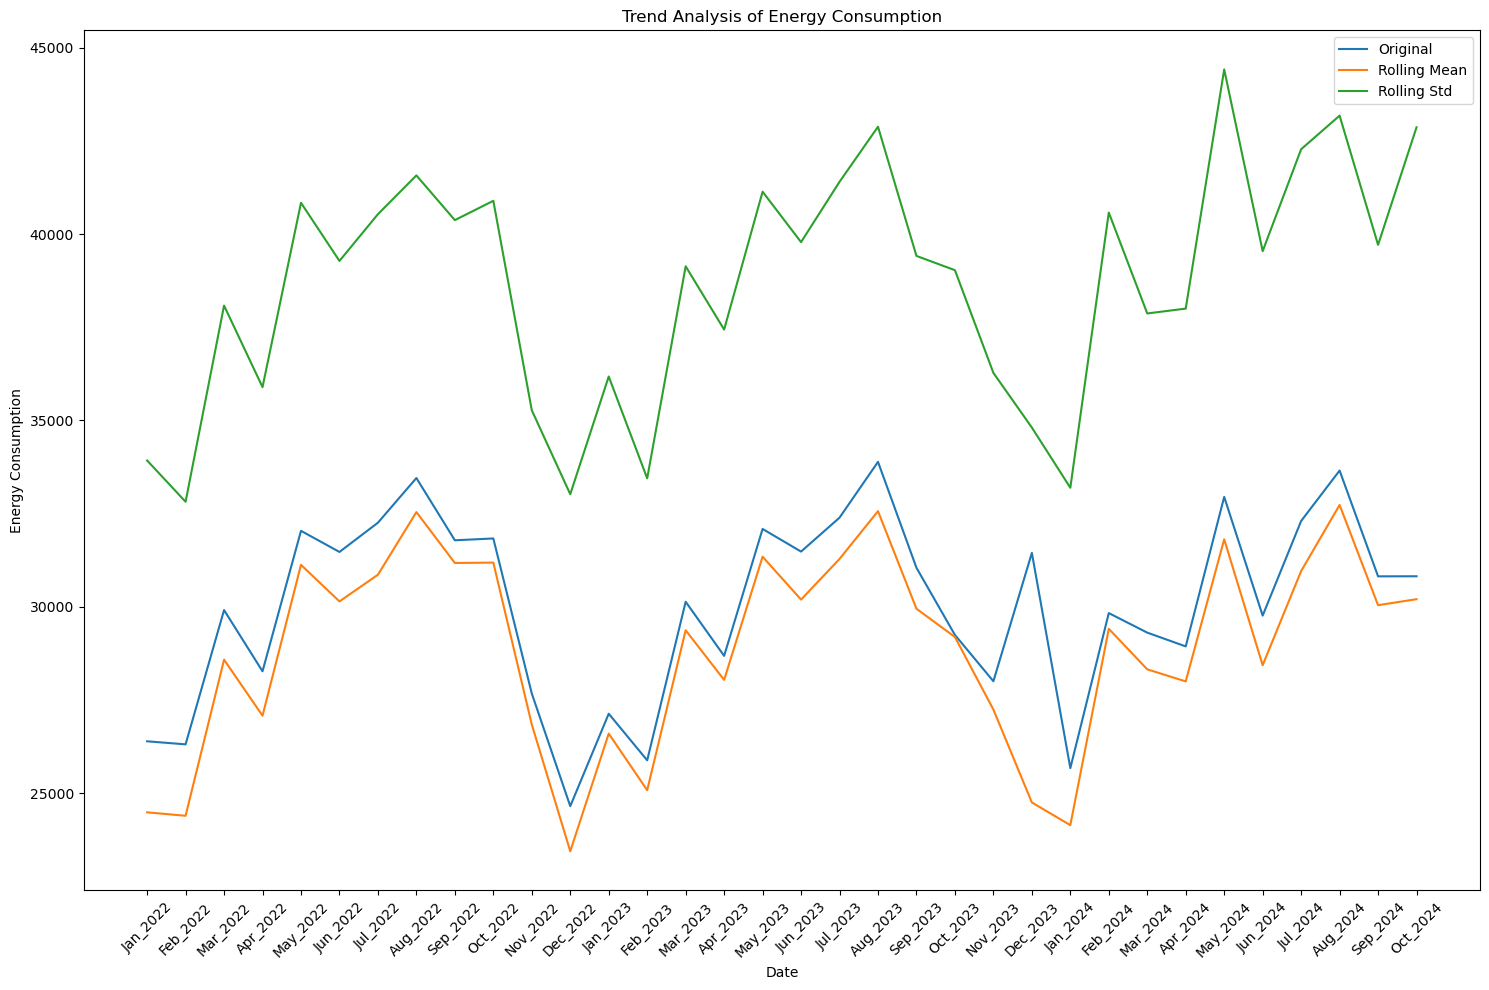

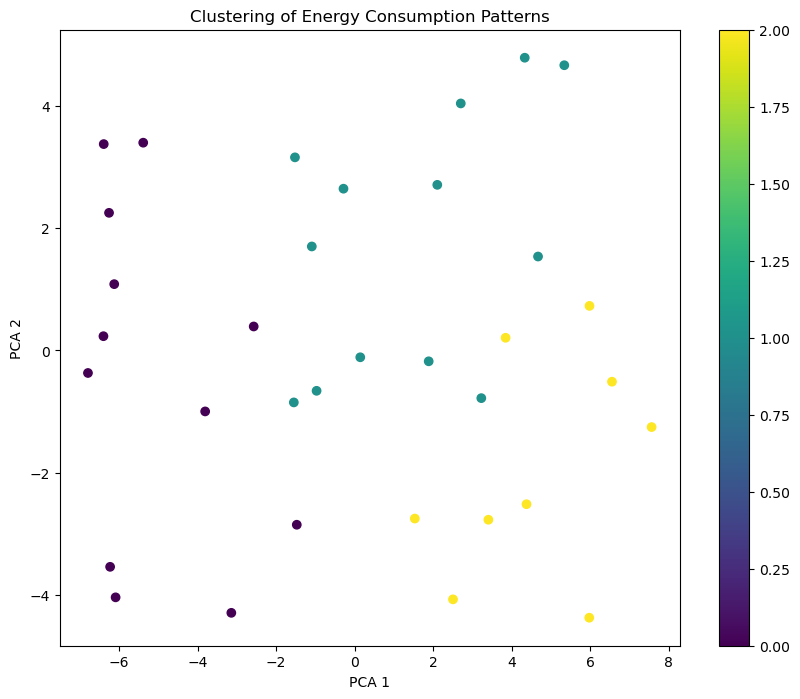


Cluster 0 Summary:
Number of points: 12
Average consumption:
27594.954616666666
Top 5 highest consuming meters:
Dec_2023    31443.9564
Mar_2022    29910.1338
Feb_2024    29828.8496
Apr_2022    28266.7712
Nov_2023    28000.4116
dtype: float64
Top 5 lowest consuming meters:
Dec_2022    24647.7150
Jan_2024    25668.3908
Feb_2023    25878.9814
Feb_2022    26306.7302
Jan_2022    26388.7542
dtype: float64

Cluster 1 Summary:
Number of points: 13
Average consumption:
30747.828846153843
Top 5 highest consuming meters:
Aug_2024    33653.7804
May_2024    32947.0322
Jul_2024    32299.8272
May_2023    32086.4022
Sep_2023    31044.9110
dtype: float64
Top 5 lowest consuming meters:
Apr_2023    28680.9670
Apr_2024    28934.8514
Oct_2023    29242.6674
Mar_2024    29304.7812
Jun_2024    29761.6758
dtype: float64

Cluster 2 Summary:
Number of points: 9
Average consumption:
32286.923066666666
Top 5 highest consuming meters:
Aug_2023    33886.6312
Aug_2022    33453.0524
Jul_2023    32389.6912
Jul_2022   

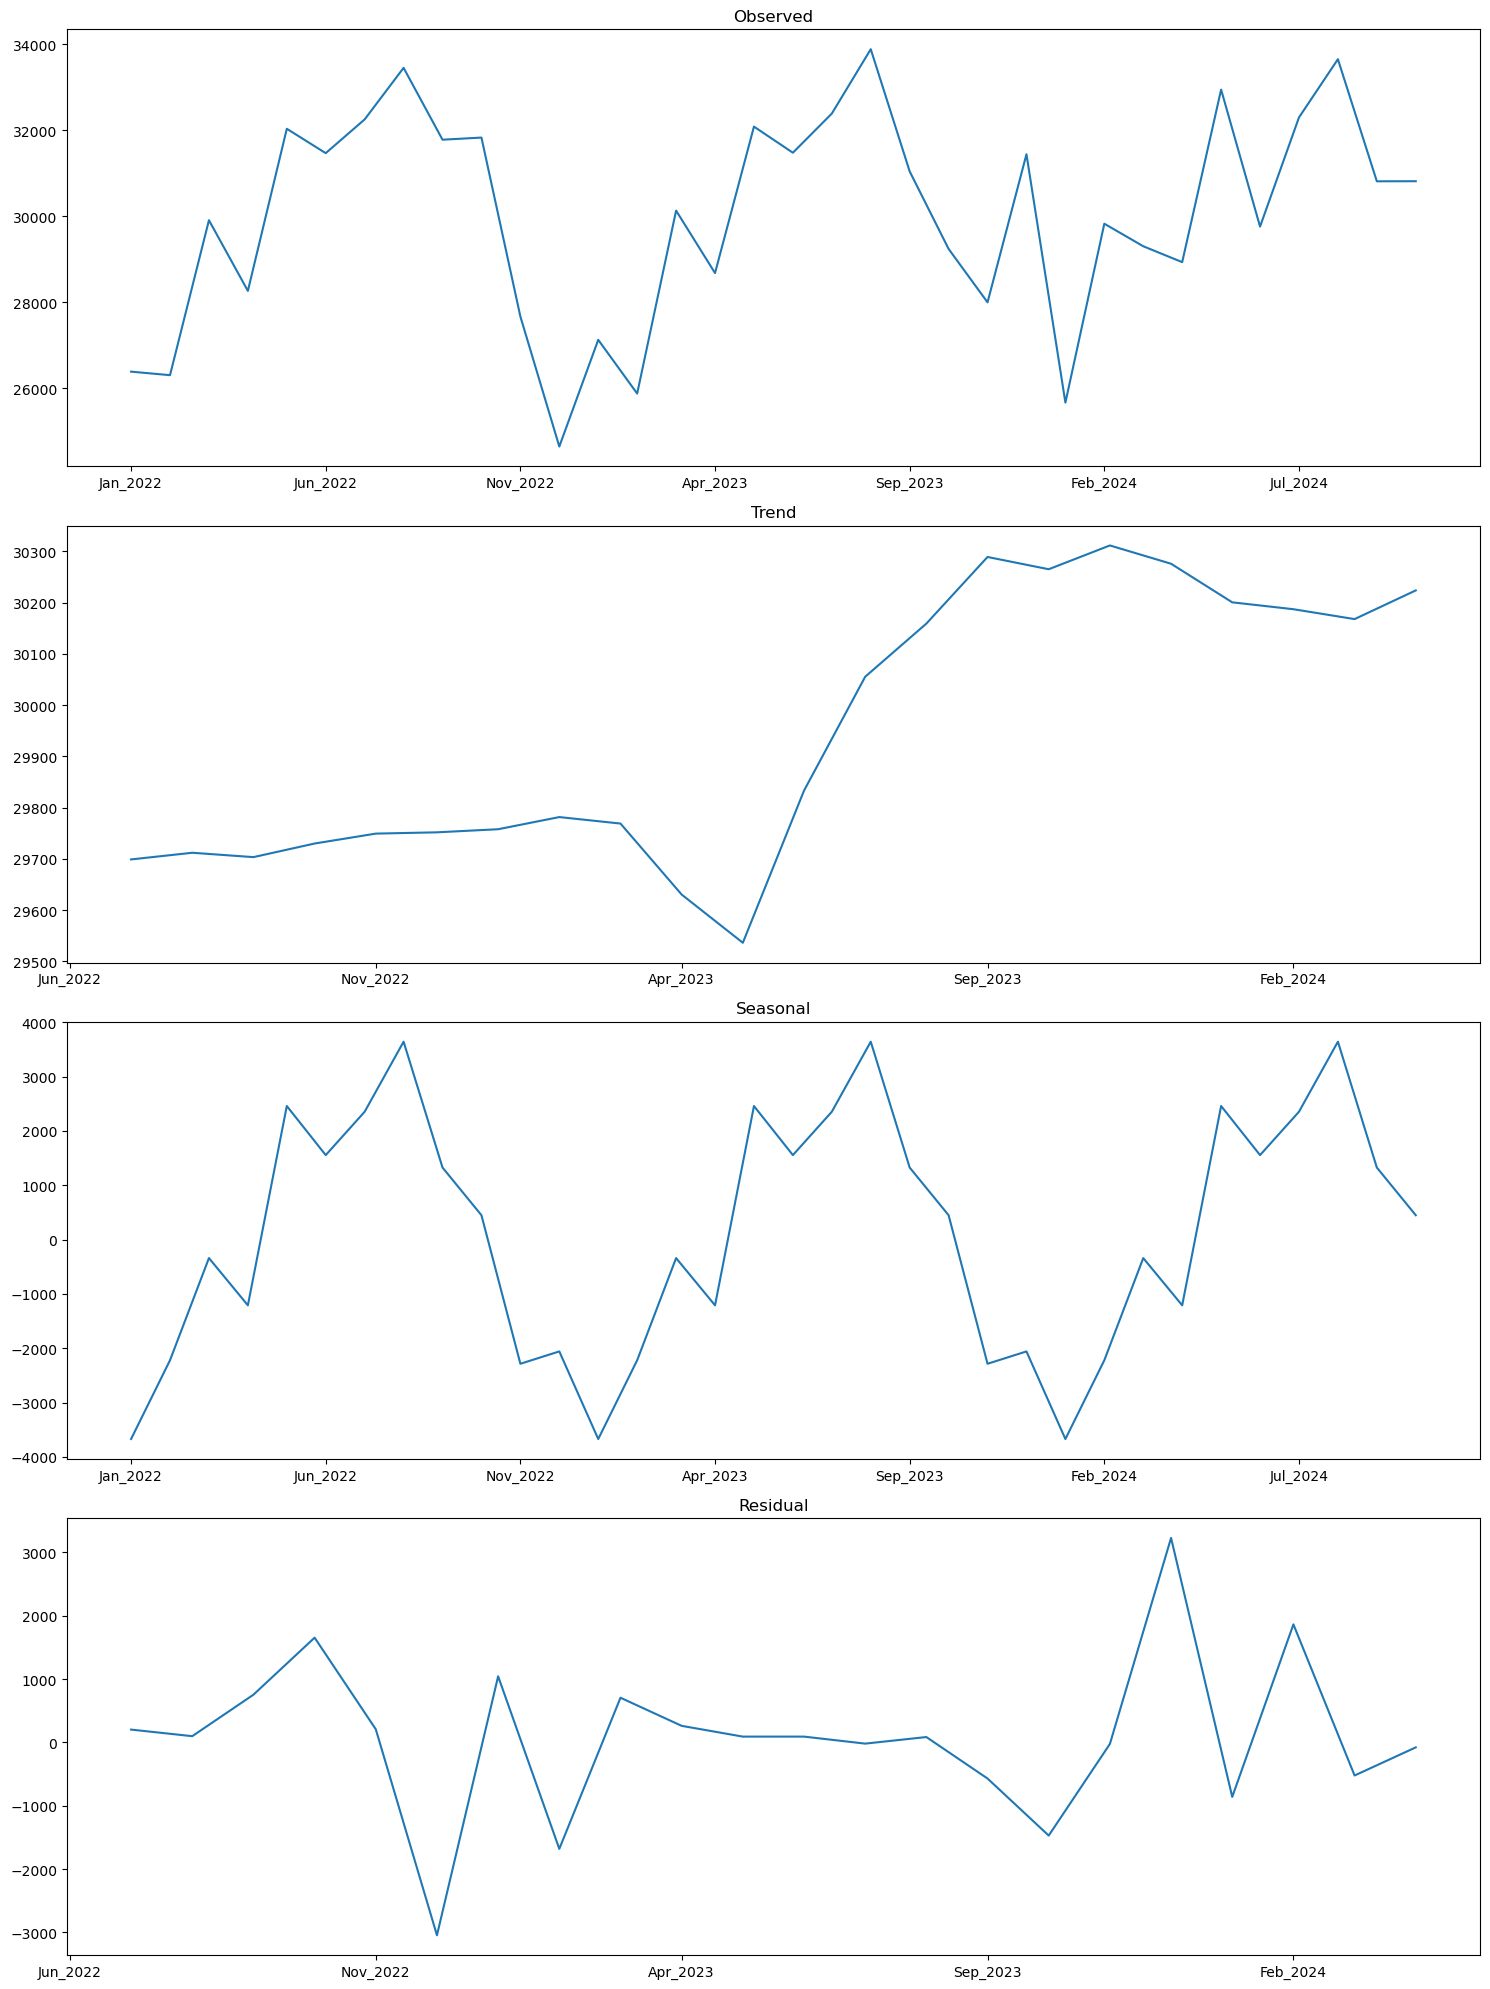

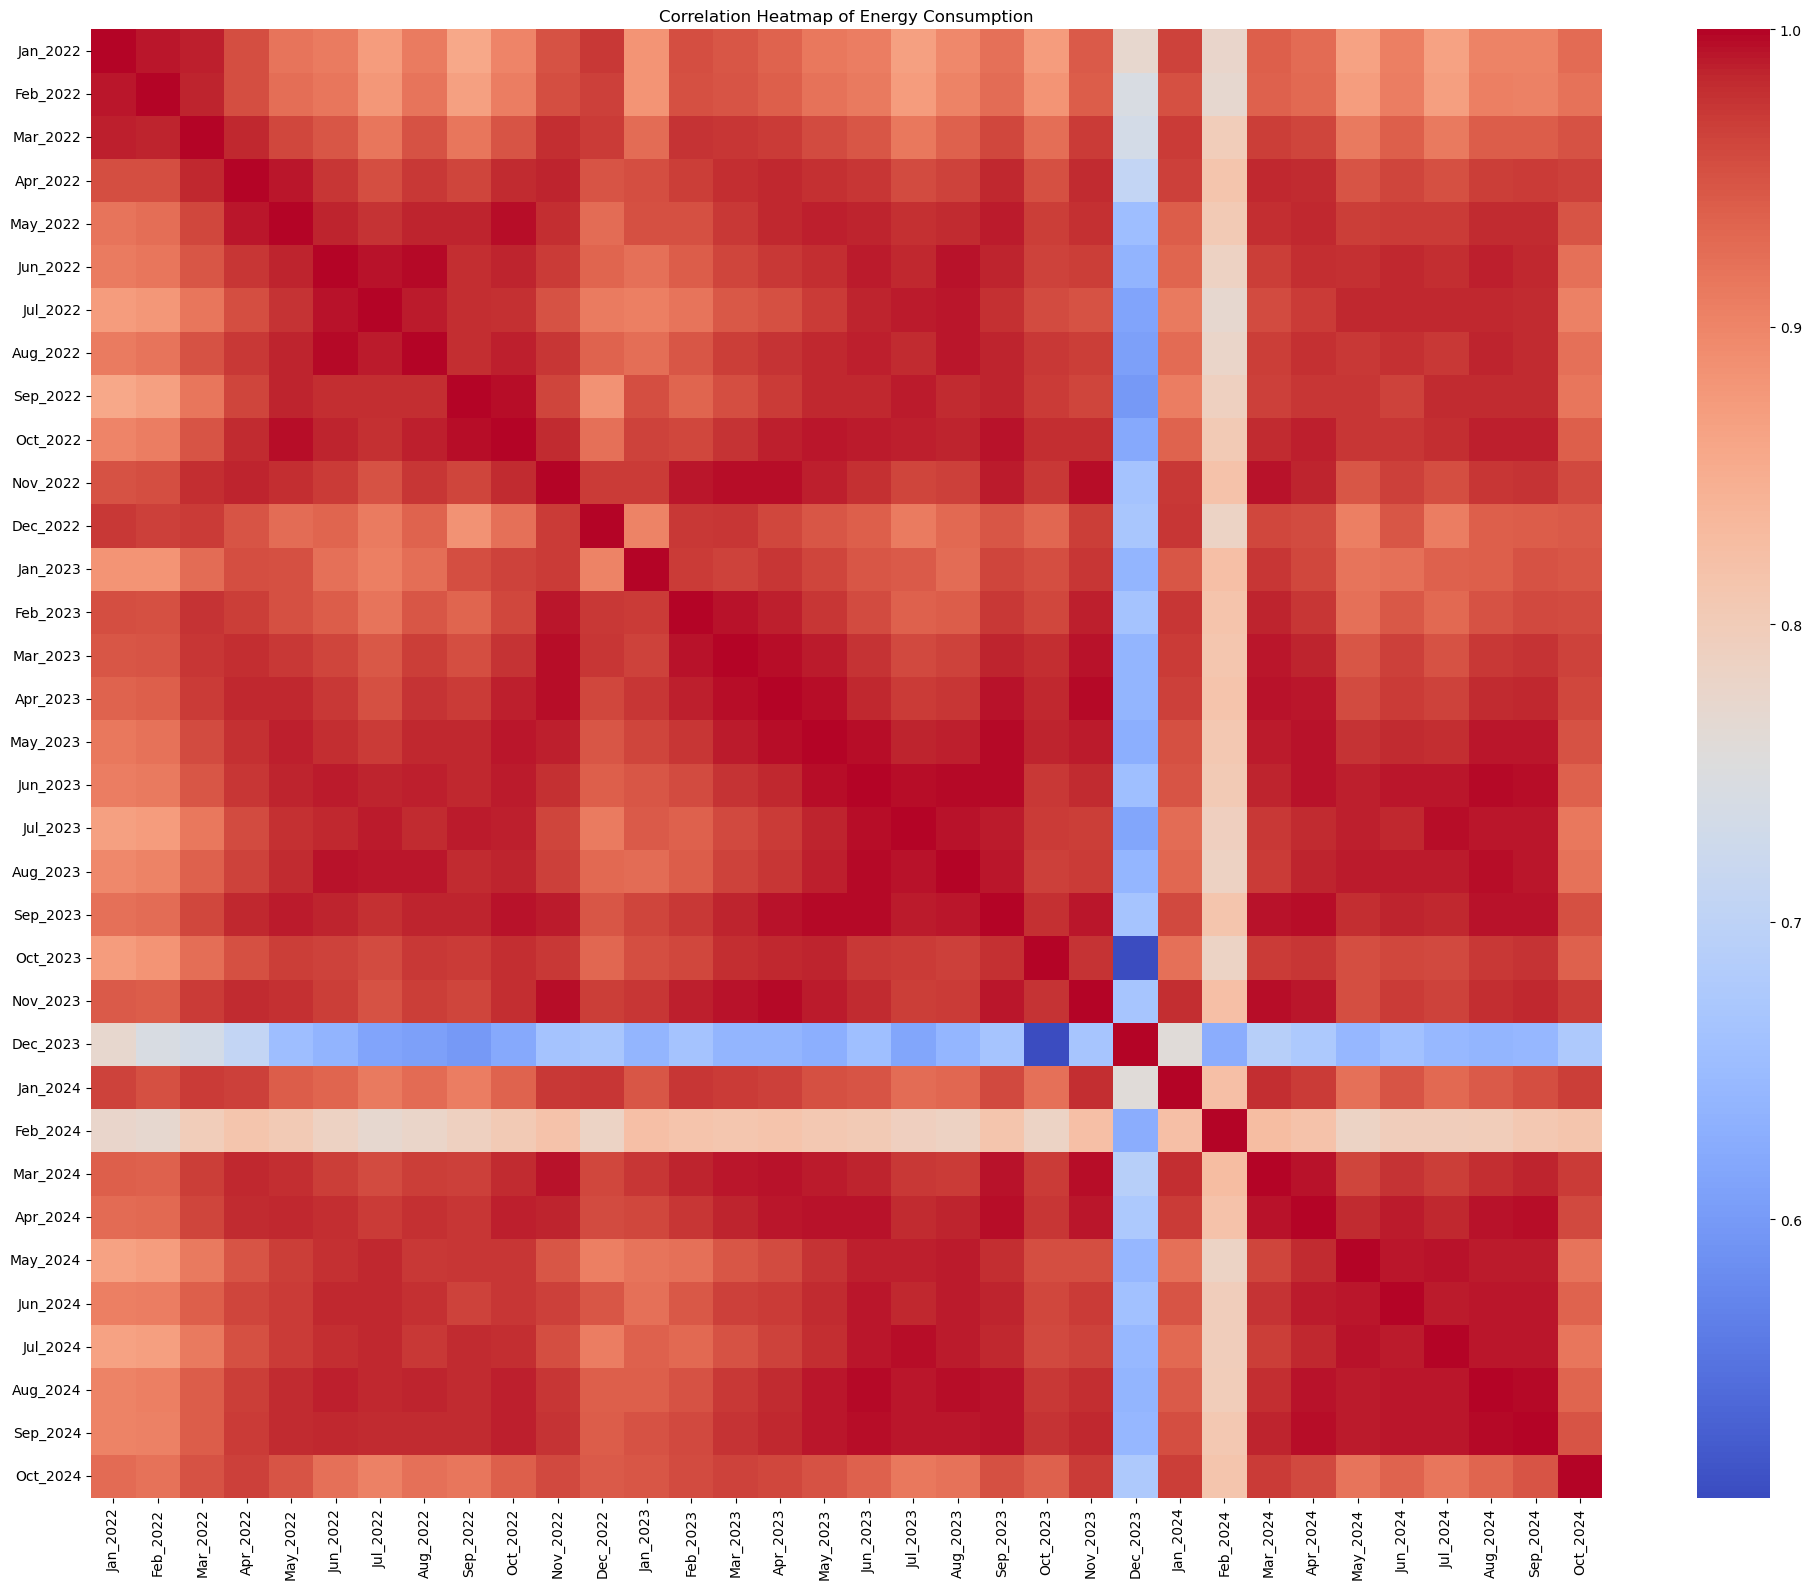

Analysis complete.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data
df = pd.read_csv('Janitza_Calculated_Consumption_Cleaned.csv')

# Set Meter_location as index
df.set_index('Meter_location', inplace=True)

# Remove Nov_2024 and Dec_2024 columns
df = df.drop(columns=['Nov_2024', 'Dec_2024'])

# Extreme Data Analysis
def extreme_data_analysis(df):
    print("Extreme Data Analysis:")
    print(df.describe())
    
    # Identify outliers using IQR method
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
    print("\nNumber of outliers in each column:")
    print(outliers)

# Trend Analysis
def trend_analysis(df):
    # Calculate rolling mean and standard deviation
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()
    
    # Plot trend
    plt.figure(figsize=(15, 10))
    plt.plot(df.columns, df.mean(), label='Original')
    plt.plot(rolling_mean.columns, rolling_mean.mean(), label='Rolling Mean')
    plt.plot(rolling_std.columns, rolling_std.mean(), label='Rolling Std')
    plt.title('Trend Analysis of Energy Consumption')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Clustering
def clustering_analysis(df):
    # Prepare data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Visualize clusters
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('Clustering of Energy Consumption Patterns')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter)
    plt.show()
    
    # Print cluster information
    for cluster in range(3):
        cluster_points = df.iloc[:, cluster_labels == cluster]
        print(f"\nCluster {cluster} Summary:")
        print(f"Number of points: {cluster_points.shape[1]}")
        print("Average consumption:")
        print(cluster_points.mean().mean())
        print("Top 5 highest consuming meters:")
        print(cluster_points.mean().nlargest(5))
        print("Top 5 lowest consuming meters:")
        print(cluster_points.mean().nsmallest(5))

# Seasonal Decomposition
def seasonal_decomposition(df):
    # Perform seasonal decomposition on the mean consumption
    mean_consumption = df.mean(axis=0)
    result = seasonal_decompose(mean_consumption, model='additive', period=12)
    
    # Plot the decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
    result.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    result.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    result.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    result.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()

# Heatmap
def create_heatmap(df):
    plt.figure(figsize=(20, 16))
    sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap of Energy Consumption')
    plt.tight_layout()
    plt.show()

# Run analyses
extreme_data_analysis(df)
trend_analysis(df)
clustering_analysis(df)
seasonal_decomposition(df)
create_heatmap(df)

print("Analysis complete.")


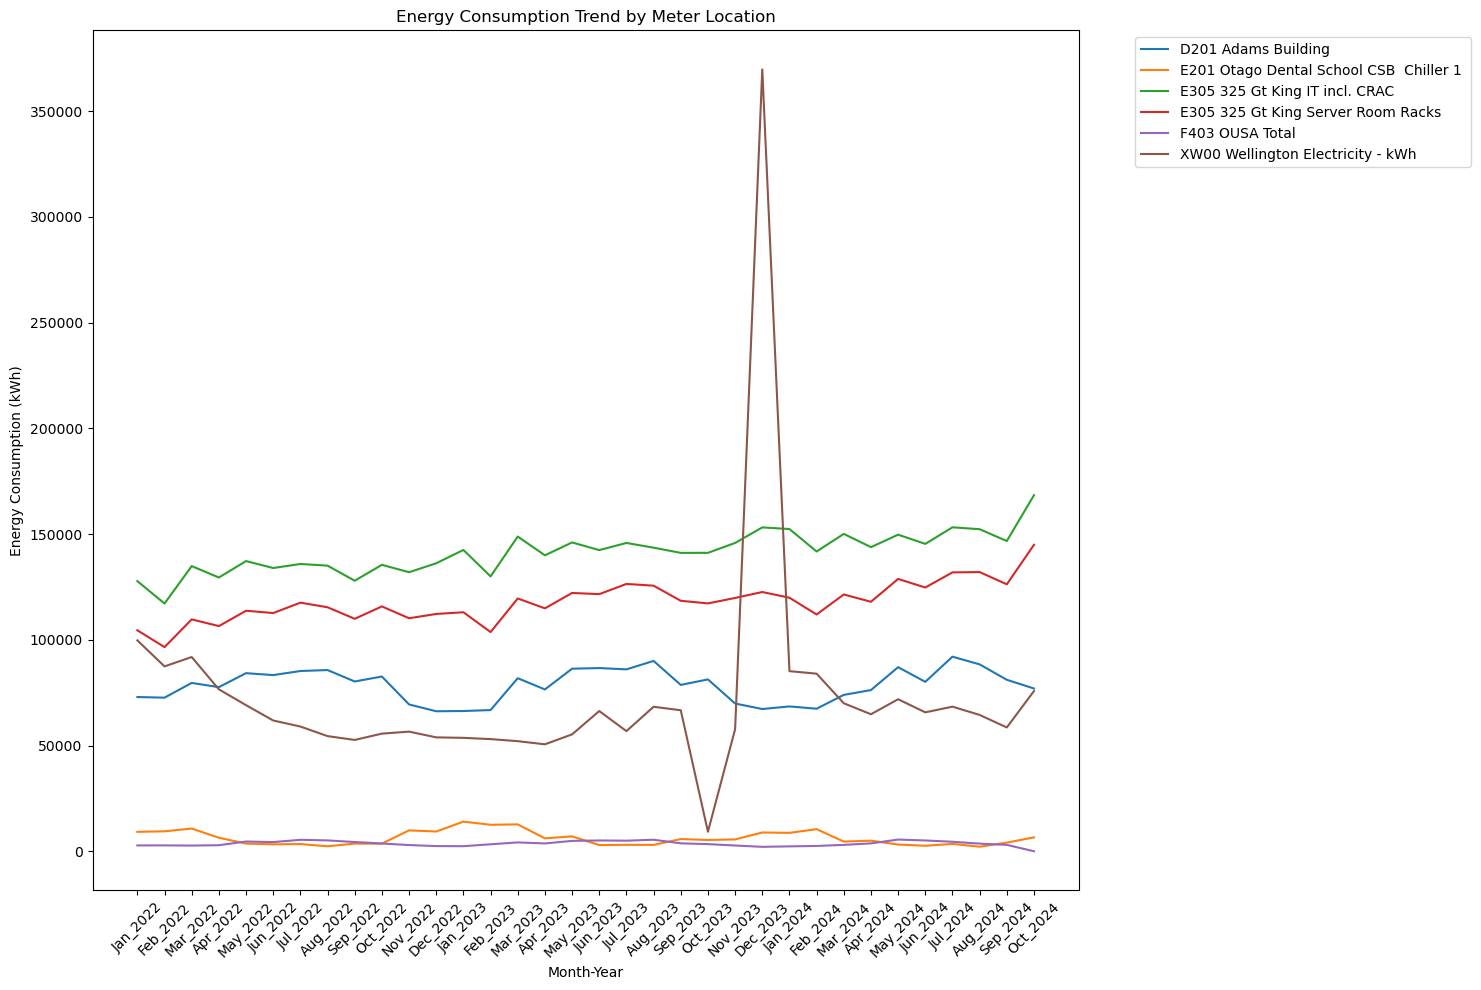

<Figure size 1500x1000 with 0 Axes>

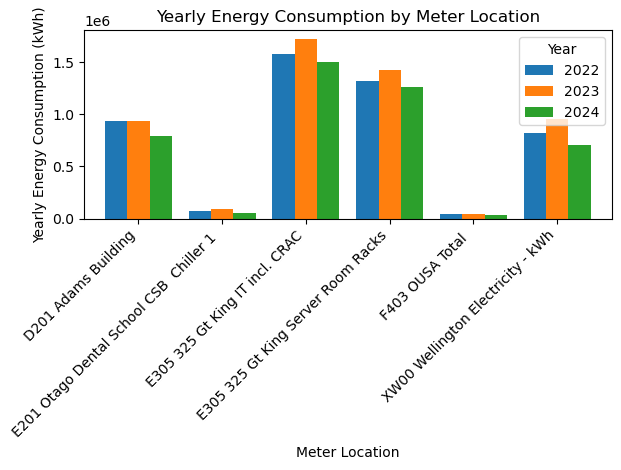

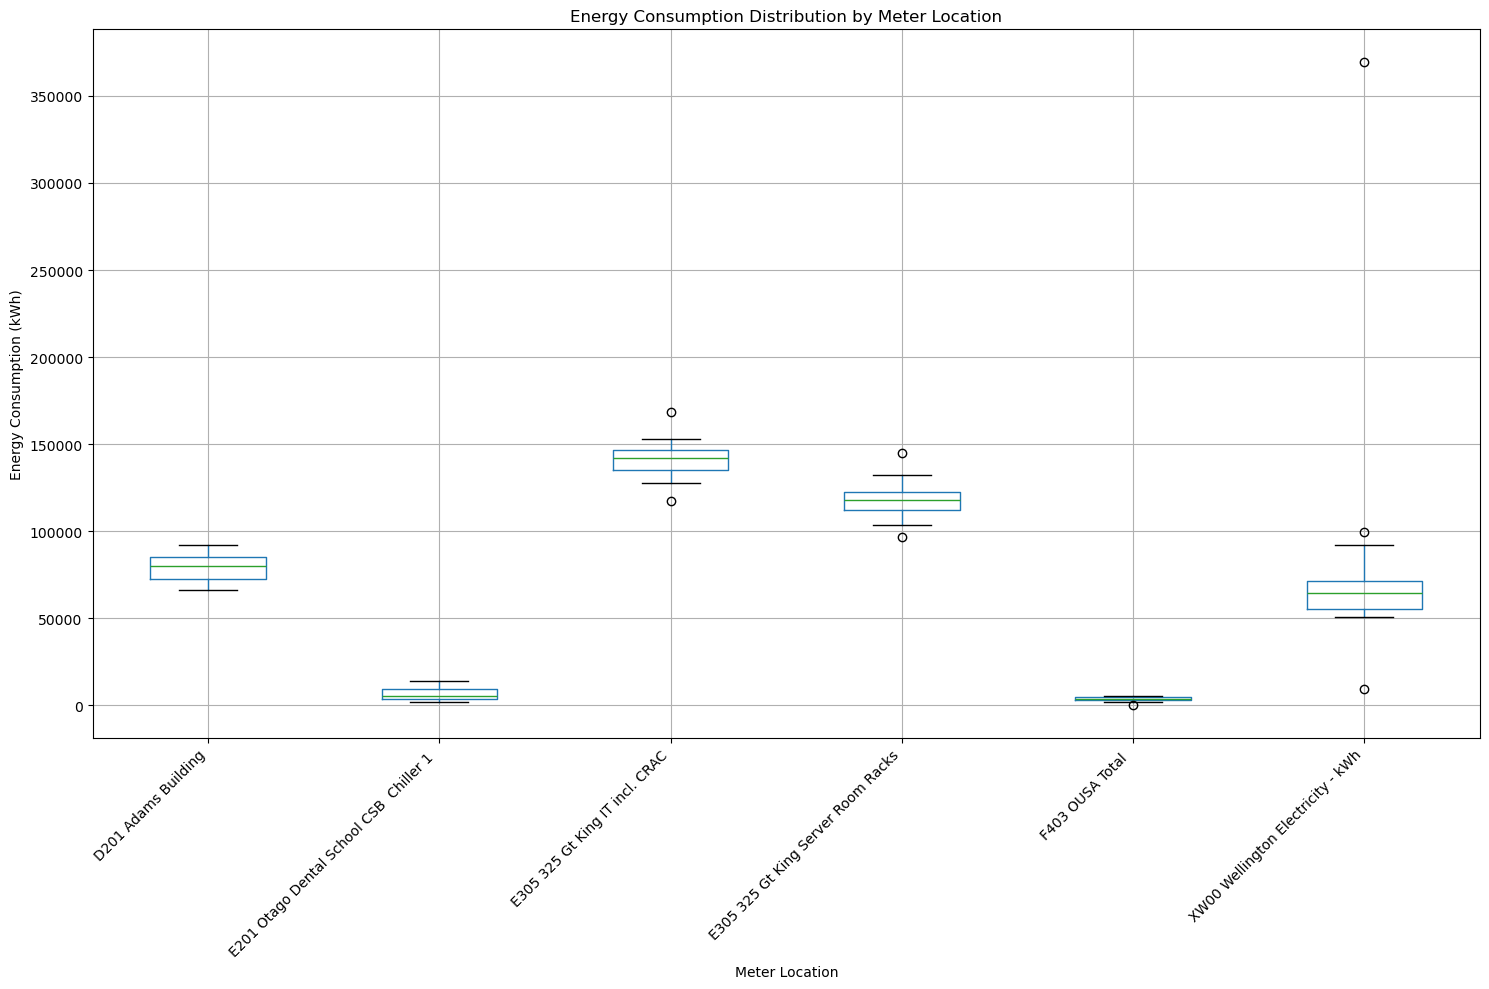

C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\93015222.py:68: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly_avg = df.loc[locations].groupby(get_month, axis=1).mean()


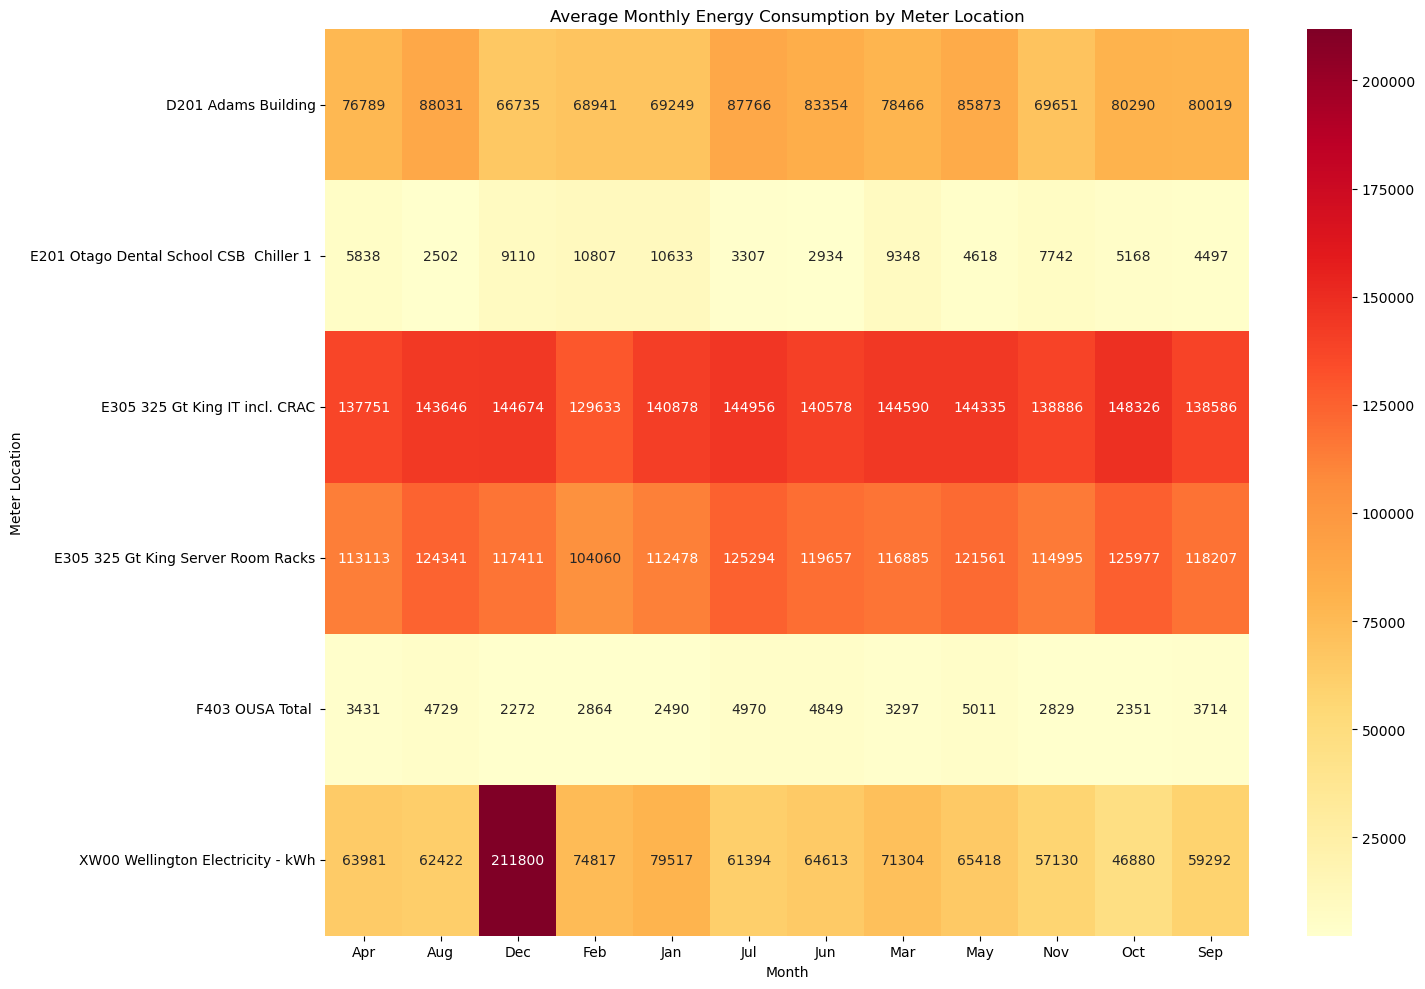

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# If it's not loaded, load it first:
# df = pd.read_csv('Janitza_Calculated_Consumption_Cleaned.csv', index_col='Meter_location')

locations = [
    'D201 Adams Building',
    'E201 Otago Dental School CSB  Chiller 1 ',
    'E305 325 Gt King IT incl. CRAC',
    'E305 325 Gt King Server Room Racks',
    'F403 OUSA Total ',
    'XW00 Wellington Electricity - kWh'
]

# Trend Analysis
plt.figure(figsize=(15, 10))
for location in locations:
    if location in df.index:
        plt.plot(df.columns, df.loc[location], label=location)
    else:
        print(f"Location '{location}' not found in the DataFrame")

plt.title('Energy Consumption Trend by Meter Location')
plt.xlabel('Month-Year')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Yearly Consumption Bar Chart
def get_yearly_consumption(df):
    yearly = {}
    for year in range(2022, 2025):
        yearly[year] = df[[col for col in df.columns if str(year) in col]].sum(axis=1)
    return pd.DataFrame(yearly)

yearly_consumption = get_yearly_consumption(df.loc[locations])

plt.figure(figsize=(15, 10))
yearly_consumption.plot(kind='bar', width=0.8)
plt.title('Yearly Energy Consumption by Meter Location')
plt.xlabel('Meter Location')
plt.ylabel('Yearly Energy Consumption (kWh)')
plt.legend(title='Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Comparison Between Locations (Box Plot)
plt.figure(figsize=(15, 10))
df.loc[locations].T.boxplot()
plt.title('Energy Consumption Distribution by Meter Location')
plt.xlabel('Meter Location')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Monthly Average Consumption
def get_month(col):
    return col[:3]

monthly_avg = df.loc[locations].groupby(get_month, axis=1).mean()

plt.figure(figsize=(15, 10))
sns.heatmap(monthly_avg, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Monthly Energy Consumption by Meter Location')
plt.xlabel('Month')
plt.ylabel('Meter Location')
plt.tight_layout()
plt.show()

C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\1809504946.py:33: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  plot_data = monthly_avg.stack().unstack(level=1).T


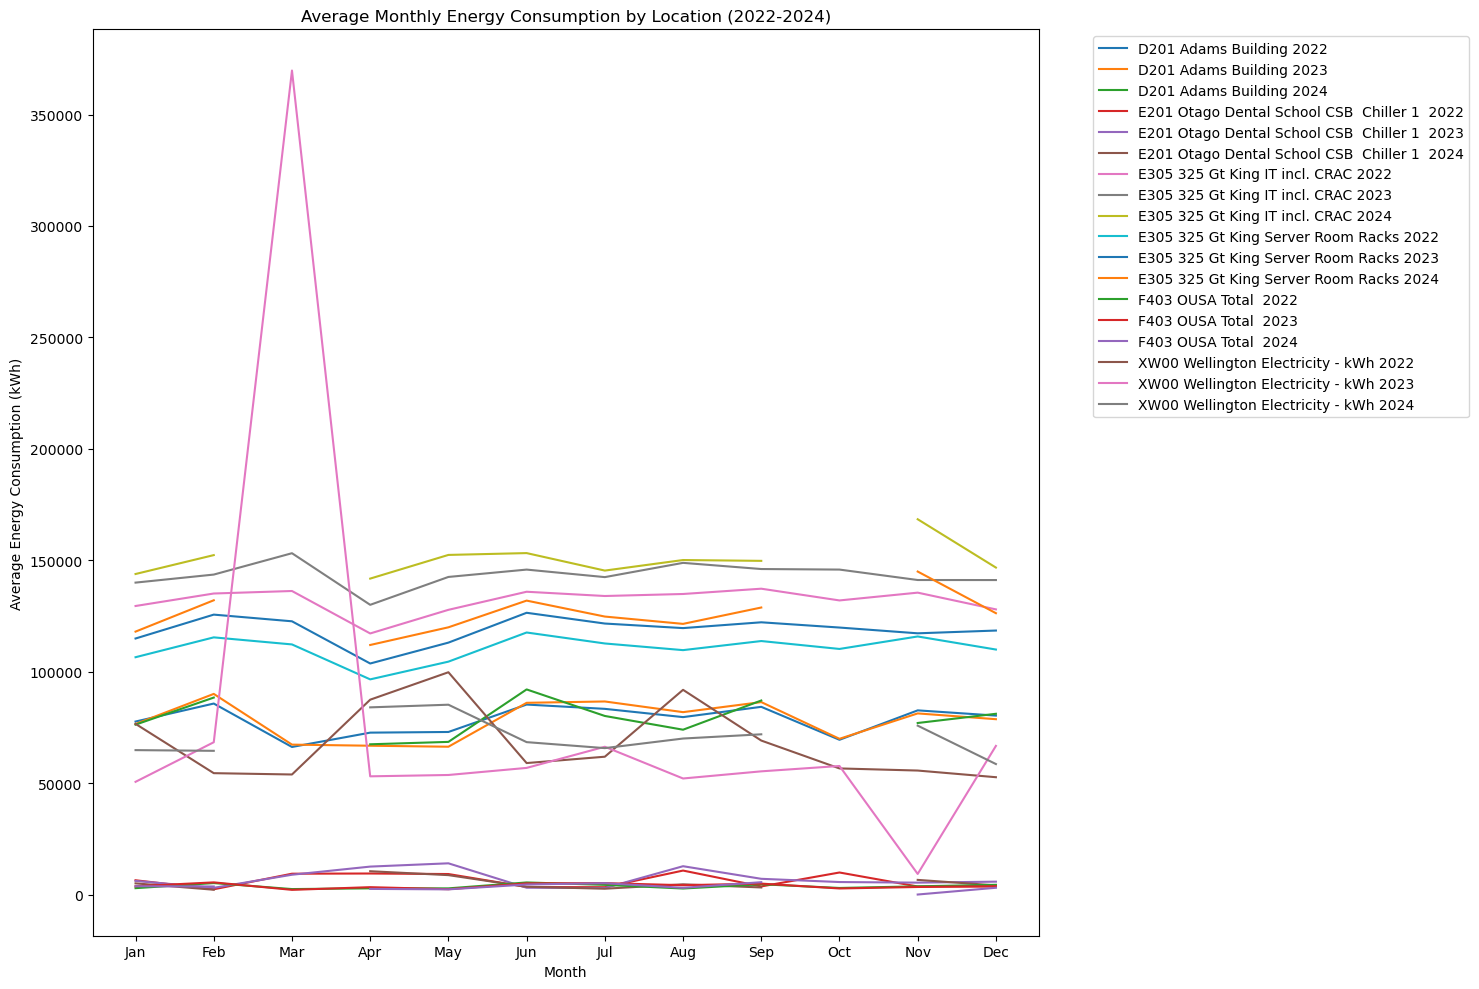

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the requested locations
locations = [
    'D201 Adams Building',
    'E201 Otago Dental School CSB  Chiller 1 ',
    'E305 325 Gt King IT incl. CRAC',
    'E305 325 Gt King Server Room Racks',
    'F403 OUSA Total ',
    'XW00 Wellington Electricity - kWh'
]

# Load the data (assuming the DataFrame is already loaded as df)
# If not, uncomment the following line:
# df = pd.read_csv('Janitza_Calculated_Consumption_Cleaned.csv', index_col='Meter_location')

# Filter the DataFrame to include only the specified locations
df_filtered = df.loc[df.index.isin(locations)]

# Function to get month from column name
def get_month(col):
    return col.split('_')[0]

# Function to get year from column name
def get_year(col):
    return col.split('_')[1]

# Calculate monthly averages for each location and year
monthly_avg = df_filtered.T.groupby([get_year, get_month]).mean().T

# Reshape data for plotting
plot_data = monthly_avg.stack().unstack(level=1).T

# Plot
fig, ax = plt.subplots(figsize=(15, 10))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = range(len(months))

available_years = monthly_avg.columns.get_level_values(0).unique()

for location in locations:
    if location in plot_data.columns:
        for year in available_years:
            ax.plot(x, plot_data[location][year], label=f'{location} {year}')

ax.set_xticks(x)
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Average Energy Consumption (kWh)')
ax.set_title('Average Monthly Energy Consumption by Location (2022-2024)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [8]:
locations

['D201 Adams Building',
 'E201 Otago Dental School CSB  Chiller 1 ',
 'E305 325 Gt King IT incl. CRAC',
 'E305 325 Gt King Server Room Racks',
 'F403 OUSA Total ',
 'XW00 Wellington Electricity - kWh']

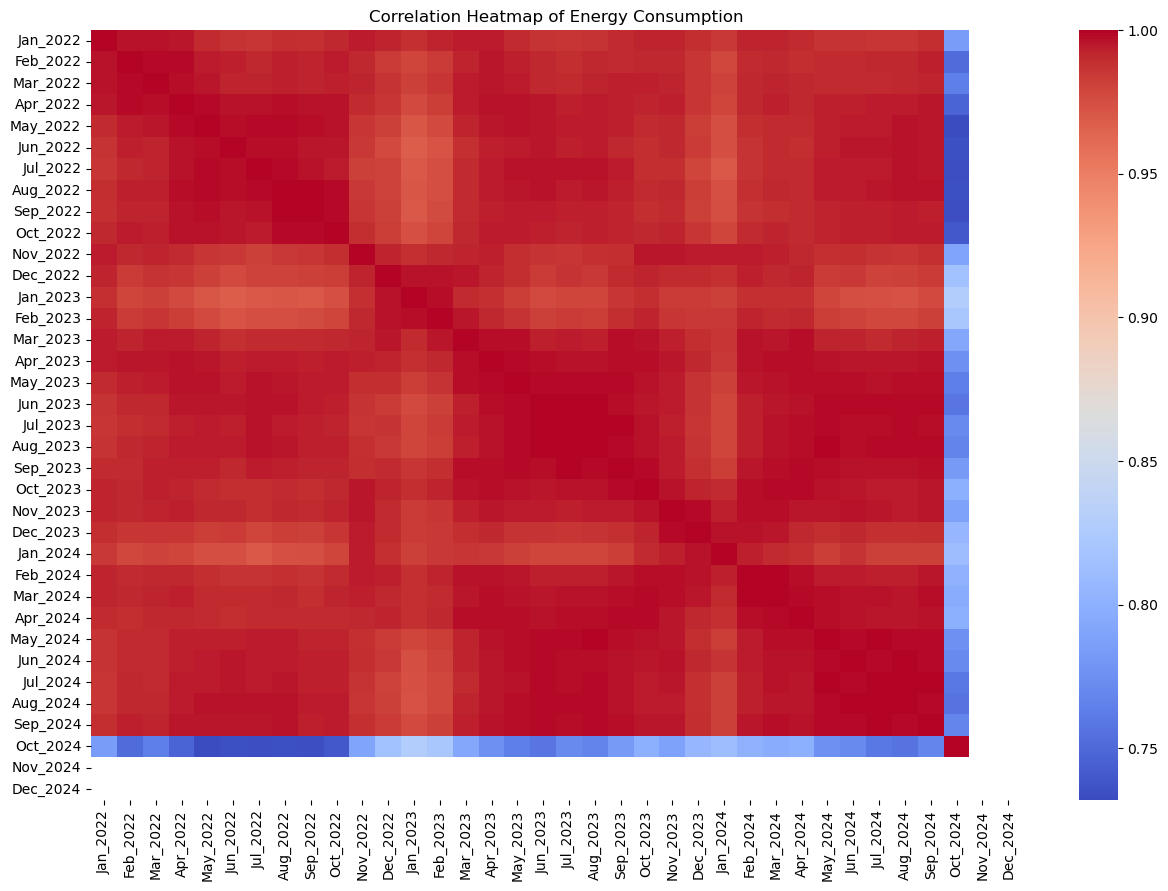

C:\Users\sugan\AppData\Local\Temp\ipykernel_15636\1775354909.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(janitza_med_data[janitza_med_data['Cluster'] == cluster].iloc[:, 1:-1].mean(axis=1), label=f'Cluster {cluster}')


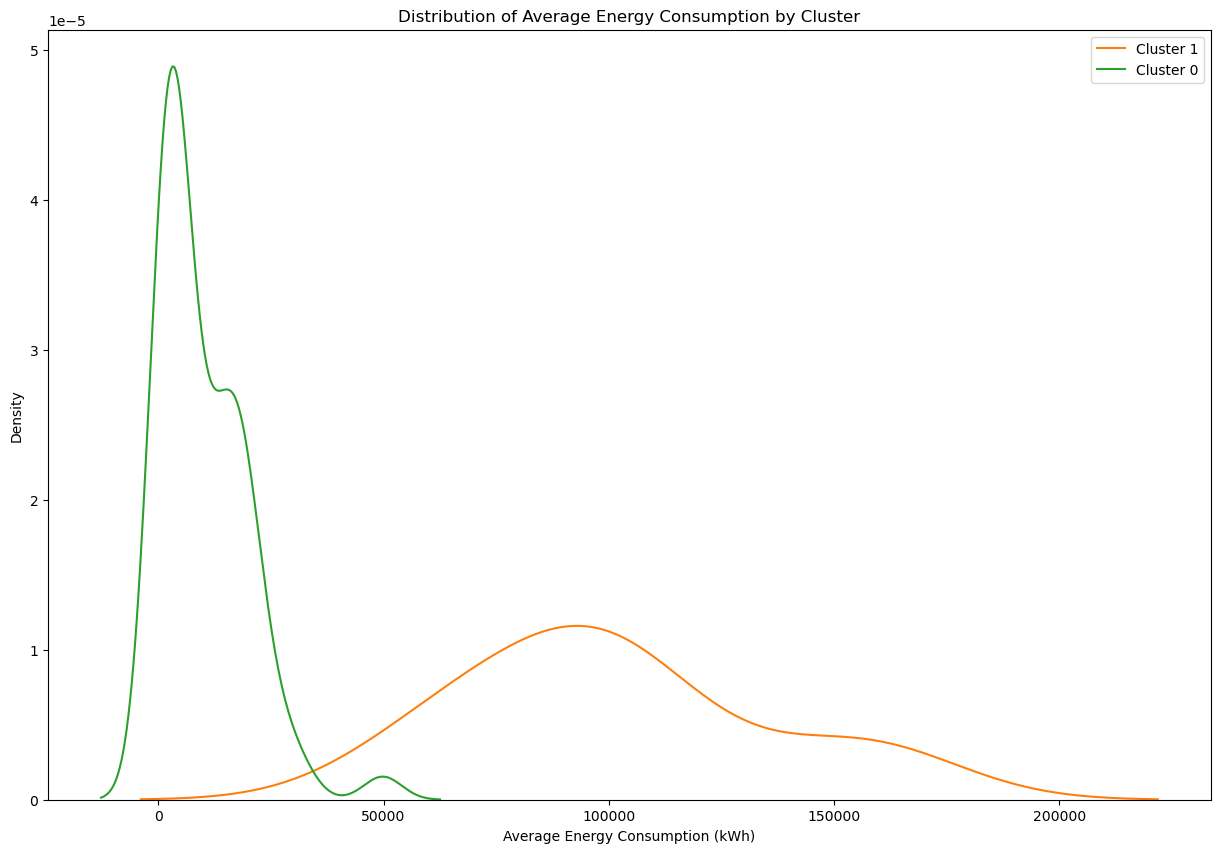

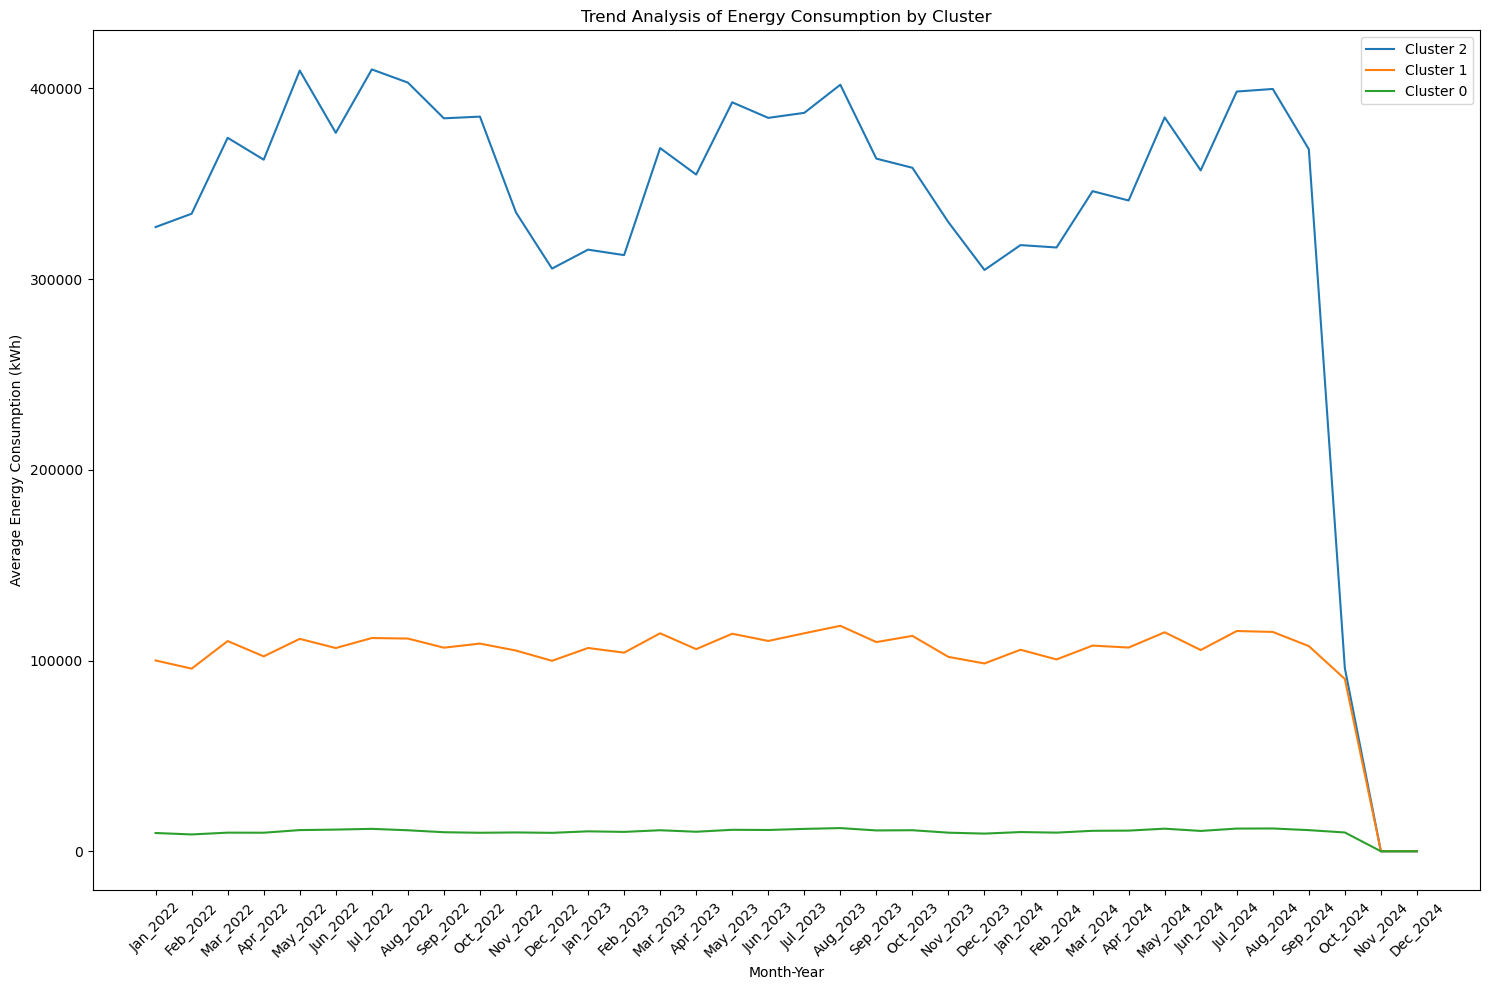

Cluster Summary:
        Jan_2022       Feb_2022       Mar_2022       Apr_2022       May_2022  \
0    9572.786885    8821.606557    9758.491803    9720.622951   11104.459016   
1  100047.700000   95755.900000  110217.300000  102194.300000  111373.800000   
2  327299.000000  334299.000000  374104.000000  362627.000000  409346.000000   

        Jun_2022       Jul_2022   Aug_2022       Sep_2022      Oct_2022  ...  \
0   11368.360656   11746.521639   11008.03    9981.406066    9697.31459  ...   
1  106558.100000  111816.100000  111532.70  106748.600000  108894.04200  ...   
2  376717.000000  409956.000000  403055.00  384319.000000  385204.22000  ...   

       Mar_2024       Apr_2024       May_2024       Jun_2024       Jul_2024  \
0   10727.68918   10830.808525   11843.190984   10659.923607   11894.556393   
1  107845.66000  106820.916000  114821.429000  105522.354000  115475.838000   
2  346120.19000  341229.560000  384794.630000  357027.840000  398360.560000   

        Aug_2024       S

In [9]:

# Load the Janitza_Med_Data_Cleaned dataset
data_path = 'Janitza_Med_Data_Cleaned.csv'
janitza_med_data = pd.read_csv(data_path)

# Prepare the data for clustering (excluding the 'Meter_location' column)
data_for_clustering = janitza_med_data.iloc[:, 1:].fillna(0)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Add cluster labels to the original dataset
janitza_med_data['Cluster'] = clusters

# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data_for_clustering.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Energy Consumption')
plt.show()

# Distribution analysis by cluster
plt.figure(figsize=(15, 10))
for cluster in janitza_med_data['Cluster'].unique():
    sns.kdeplot(janitza_med_data[janitza_med_data['Cluster'] == cluster].iloc[:, 1:-1].mean(axis=1), label=f'Cluster {cluster}')
plt.title('Distribution of Average Energy Consumption by Cluster')
plt.xlabel('Average Energy Consumption (kWh)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Trend analysis for clusters
plt.figure(figsize=(15, 10))
for cluster in janitza_med_data['Cluster'].unique():
    cluster_data = janitza_med_data[janitza_med_data['Cluster'] == cluster].iloc[:, 1:-1].mean()
    plt.plot(cluster_data.index, cluster_data.values, label=f'Cluster {cluster}')
plt.title('Trend Analysis of Energy Consumption by Cluster')
plt.xlabel('Month-Year')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Cluster summary
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=janitza_med_data.columns[1:-1])
print("Cluster Summary:")
print(cluster_summary)


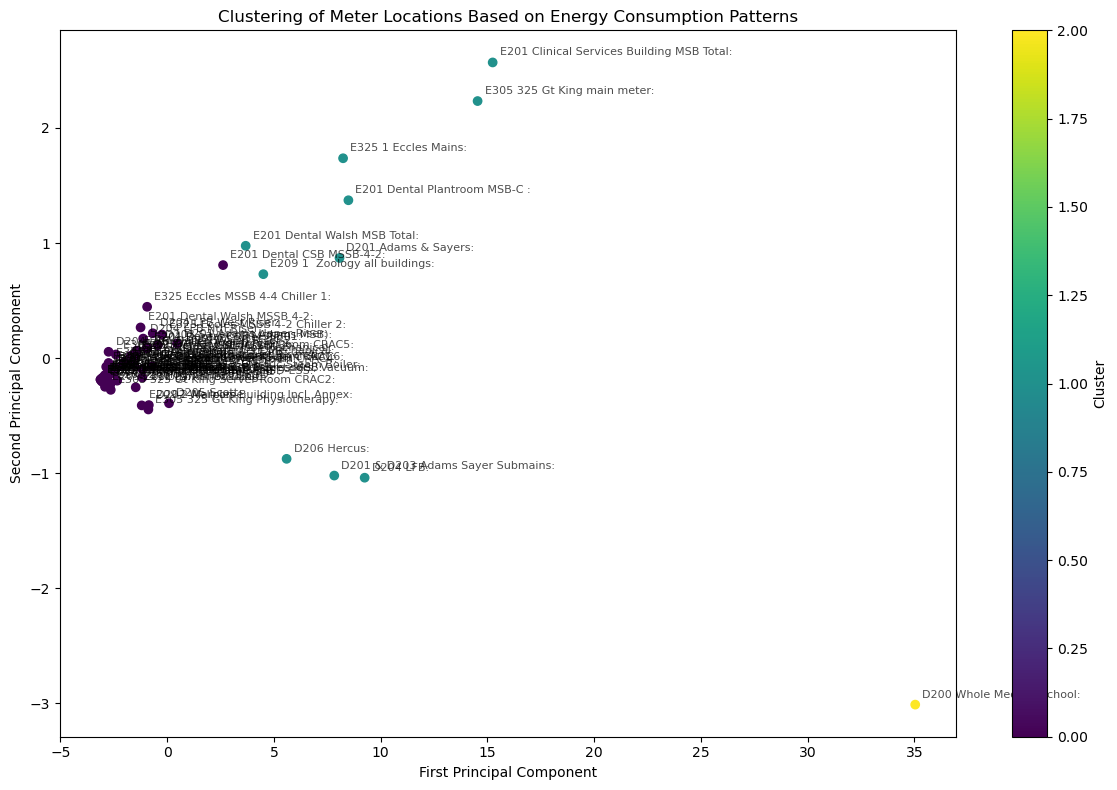


Cluster 0 locations:
['D201 Adams 7th Floor Mechanical:' 'D201 Adams Basement Mechanical:'
 'D201 Adams Lift:' 'D201 Adams Lower Riser:' 'D201 Adams Upper Riser:'
 'D202 Wellcome:' 'D203 Sayers (at Adams MSB):' 'D204 LFB Chiller:'
 'D204 LFB DBB1:' 'D204 LFB DBB2:' 'D204 LFB DBB4:' 'D204 LFB DBB5:'
 'D204 LFB Nth Riser:' 'D204 LFB Sth Riser:' 'D204 LFB West Riser:'
 'D205 Scott:' 'D207 Generator:' 'D207 Nitrogenplant:'
 'D207 Thermal Storage IT:' 'D207 Thermal Storage plant :'
 'E201 Busduct Riser 3:' 'E201 Dental CSB Busduct Riser 4:'
 'E201 Dental CSB DB-C-CSSD-ESS:' 'E201 Dental CSB DB-C-WS:'
 'E201 Dental CSB DB-CSSD:' 'E201 Dental CSB MSSB-4-2:'
 'E201 Dental CSB MSSB01:' 'E201 Dental CSB MSSD02:'
 'E201 Dental Walsh MSSB 0-3:' 'E201 Dental Walsh MSSB 1-1:'
 'E201 Dental Walsh MSSB 4-2:' 'E201 Dental Walsh MSSB 5-1:'
 'E201 Dental Walsh Riser 1:' 'E201 Dental Walsh Riser 2:'
 'E209 2 Marples Building Incl. Annex:' 'E209 Zoology Annex DBGC:'
 'E209 Zoology Annex DBGD:' 'E211 Parke

In [10]:
data_path = 'Janitza_Med_Data_Cleaned.csv'
janitza_med_data = pd.read_csv(data_path)

# Prepare data for clustering (excluding the Meter_location column)
X = janitza_med_data.iloc[:, 1:].values
meter_locations = janitza_med_data['Meter_location']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality to 2D for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering of Meter Locations Based on Energy Consumption Patterns')

# Add legend
plt.colorbar(scatter, label='Cluster')

# Add annotations for meter locations
for i, location in enumerate(meter_locations):
    plt.annotate(location, (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Print cluster information
for cluster in range(3):
    print(f"\nCluster {cluster} locations:")
    print(meter_locations[clusters == cluster].values)

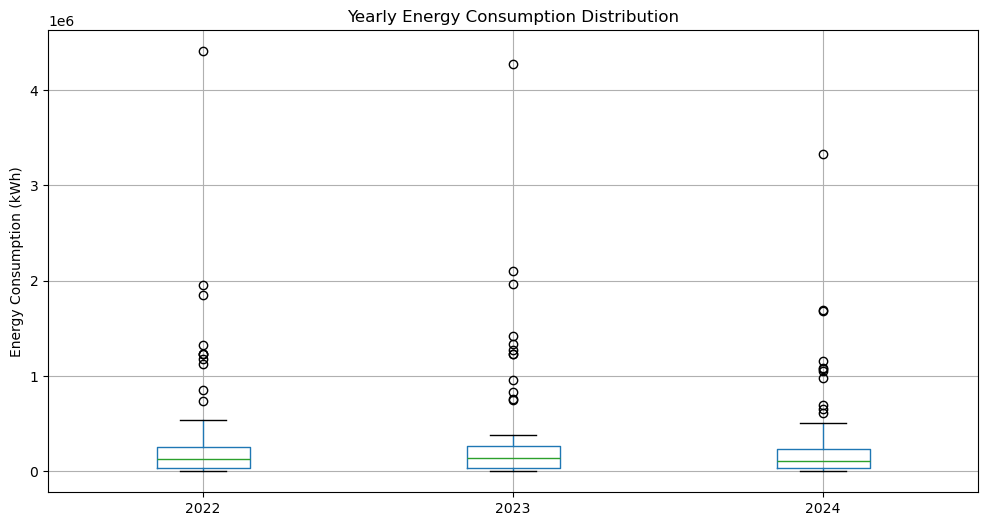

Locations with Anomalous Consumption Patterns:
Index(['D200 Whole Medical School:', 'D204 LFB:', 'D206 Hercus:',
       'E201 Clinical Services Building MSB Total:',
       'E201 Dental CSB MSSB-4-2:', 'E209 1  Zoology all buildings:',
       'E305 325 Gt King main meter:', 'E325 1 Eccles Mains:'],
      dtype='object', name='Meter_location')

Locations with Statistical Anomalies (Z-score):
Index(['D200 Whole Medical School:',
       'E201 Clinical Services Building MSB Total:',
       'E305 325 Gt King main meter:'],
      dtype='object', name='Meter_location')


In [11]:

# Load the data
df = pd.read_csv('Jantiza_Med_Data_Cleaned.csv')
df.set_index('Meter_location', inplace=True)

# 1. Year-over-Year Analysis
def yearly_analysis(df):
    # Calculate yearly totals
    yearly_consumption = {}
    for year in ['2022', '2023', '2024']:
        yearly_consumption[year] = df[[col for col in df.columns if year in col]].sum(axis=1)
    
    yearly_df = pd.DataFrame(yearly_consumption)
    
    # Plot yearly comparison
    plt.figure(figsize=(12, 6))
    yearly_df.boxplot()
    plt.title('Yearly Energy Consumption Distribution')
    plt.ylabel('Energy Consumption (kWh)')
    plt.show()
    
    return yearly_df

# 2. Anomaly Detection using IsolationForest
def detect_anomalies(df):
    # Prepare data for anomaly detection
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    
    # Train IsolationForest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomalies = iso_forest.fit_predict(data_scaled)
    
    # Get anomalous locations
    anomaly_indices = np.where(anomalies == -1)[0]
    anomalous_locations = df.index[anomaly_indices]
    
    return anomalous_locations

# 3. Statistical Analysis for Monthly Patterns
def monthly_pattern_analysis(df):
    # Calculate monthly averages
    monthly_avg = {}
    for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        monthly_avg[month] = df[[col for col in df.columns if col.startswith(month)]].mean(axis=1)
    
    monthly_df = pd.DataFrame(monthly_avg)
    
    # Plot heatmap of monthly patterns
    plt.figure(figsize=(15, 10))
    sns.heatmap(monthly_df, cmap='YlOrRd', annot=True)
    plt.title('Monthly Energy Consumption Patterns')
    plt.show()
    
    return monthly_df

# 4. Z-score based Anomaly Detection
def zscore_anomalies(df, threshold=3):
    z_scores = stats.zscore(df)
    anomalies = np.abs(z_scores) > threshold
    
    # Get locations with anomalous readings
    anomaly_locations = df.index[anomalies.any(axis=1)]
    return anomaly_locations

# Execute analyses
yearly_df = yearly_analysis(df)
anomalous_locations = detect_anomalies(df)
#monthly_patterns = monthly_pattern_analysis(df)
zscore_anomalies = zscore_anomalies(df)

# Print findings
print("Locations with Anomalous Consumption Patterns:")
print(anomalous_locations)
print("\nLocations with Statistical Anomalies (Z-score):")
print(zscore_anomalies)


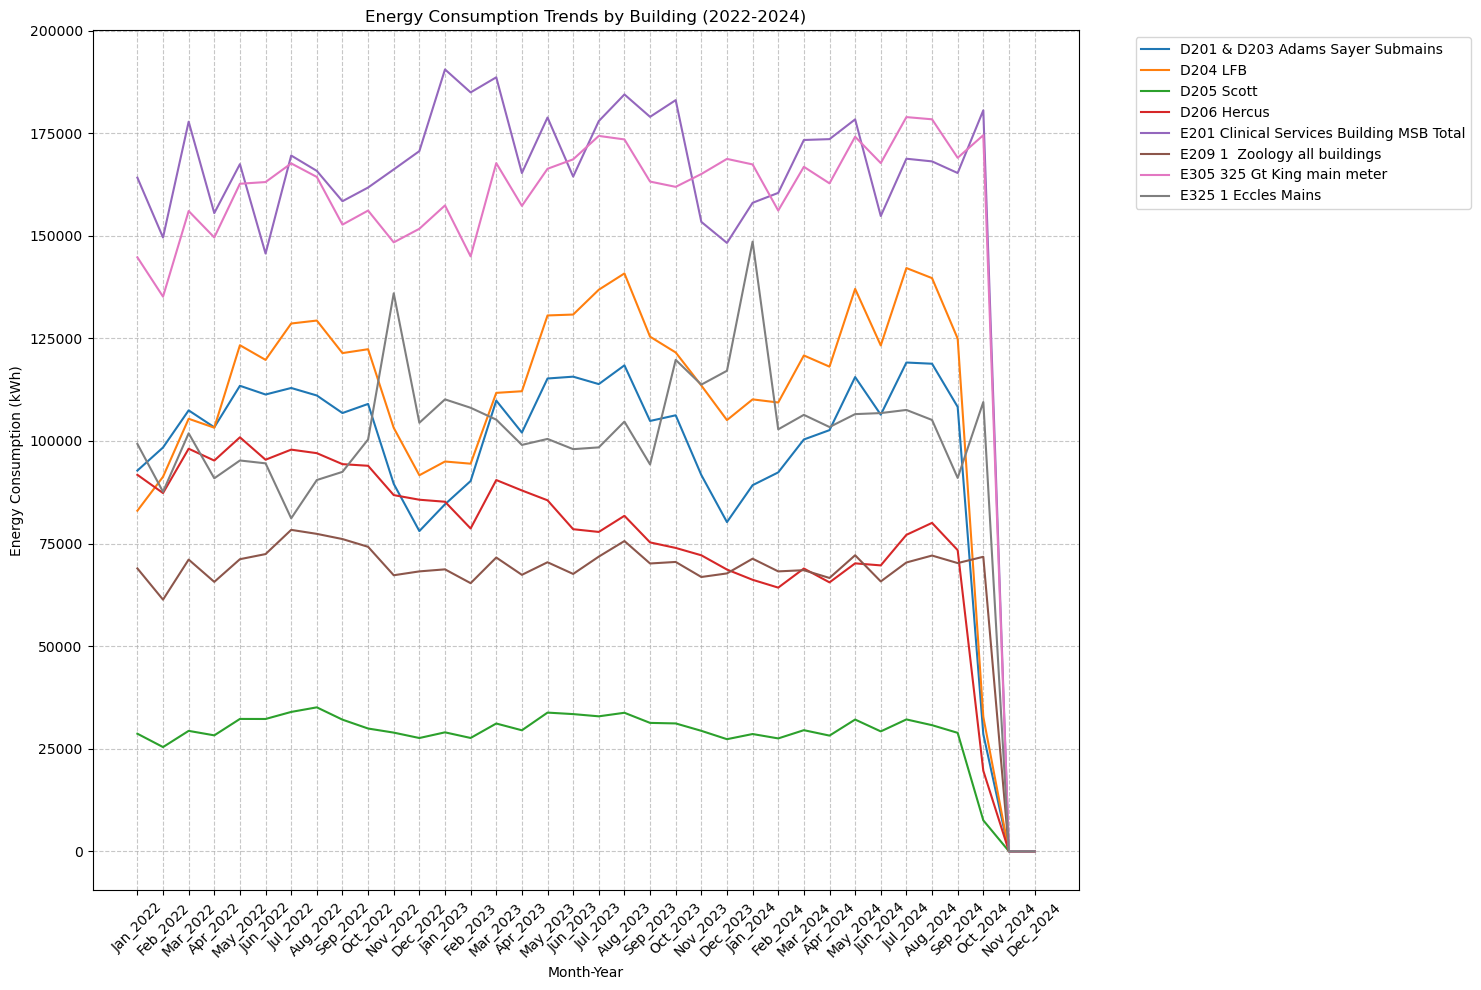


Yearly Averages (kWh):
                                                 2022       2023       2024
Meter_location                                                             
D201 & D203 Adams Sayer Submains:           102849.51  102746.20   81778.60
D204 LFB:                                   110219.80  118167.47   96532.14
D205 Scott:                                  30306.71   30850.24   22863.02
D206 Hercus:                                 93702.56   79659.09   54573.31
E201 Clinical Services Building MSB Total:  162727.49  174908.24  140124.12
E209 1  Zoology all buildings:               71008.97   69475.75   58085.12
E305 325 Gt King main meter:                154367.10  164101.97  141328.64
E325 1 Eccles Mains:                         97864.47  105751.77   90640.83


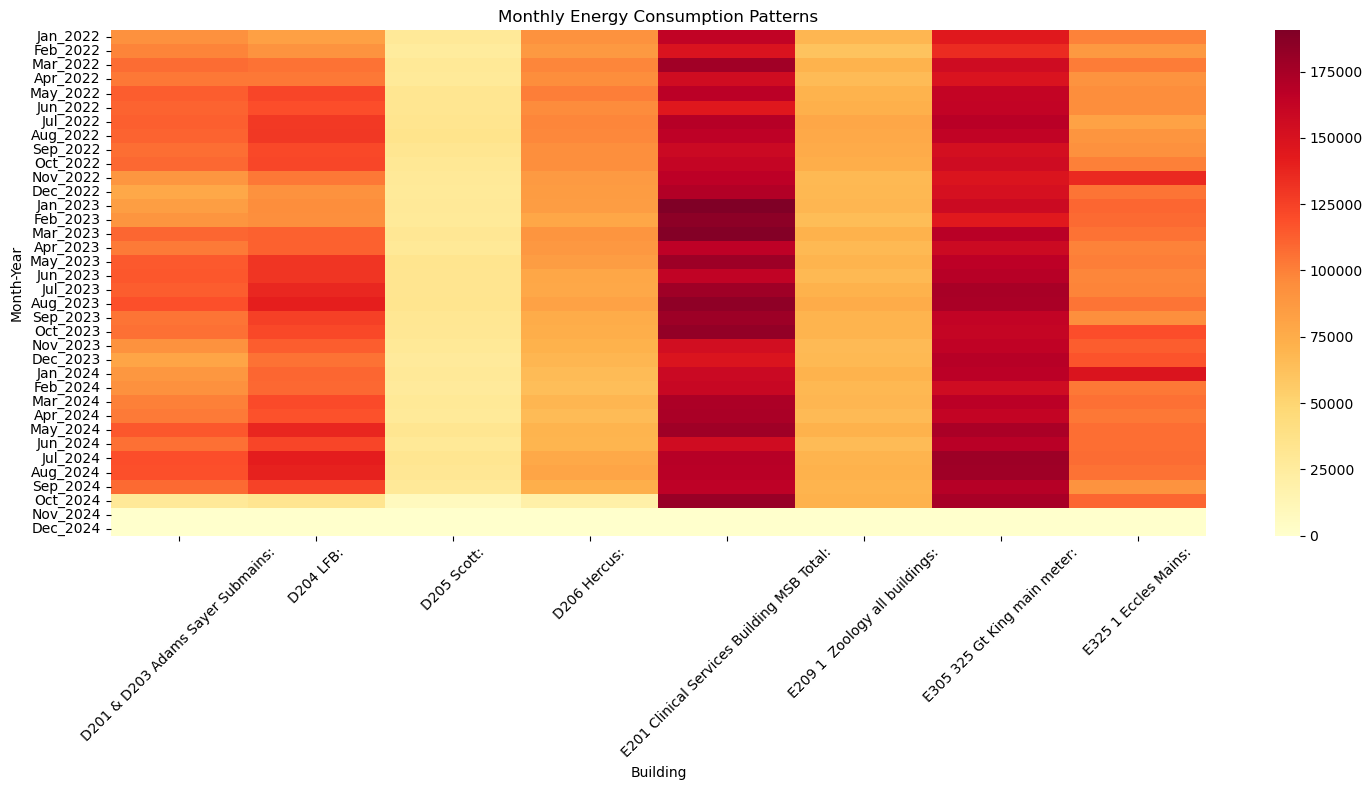

In [12]:
# Specify the locations to analyze
locations = [
    'D201 & D203 Adams Sayer Submains:',
    'D204 LFB:',
    'D205 Scott:',
    'D206 Hercus:',
    'E201 Clinical Services Building MSB Total:',
    'E209 1  Zoology all buildings:',
    'E305 325 Gt King main meter:',
    'E325 1 Eccles Mains:'
]

# Create the plot
plt.figure(figsize=(15, 10))

# Plot trend for each location
for location in locations:
    plt.plot(df.columns, df.loc[location], label=location.replace(':', ''))

# Customize the plot
plt.title('Energy Consumption Trends by Building (2022-2024)')
plt.xlabel('Month-Year')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and display yearly averages
def calculate_yearly_averages(df, locations):
    yearly_avg = {}
    for year in ['2022', '2023', '2024']:
        year_cols = [col for col in df.columns if year in col]
        yearly_avg[year] = df.loc[locations, year_cols].mean(axis=1)
    
    return pd.DataFrame(yearly_avg)

# Calculate and display yearly averages
yearly_averages = calculate_yearly_averages(df, locations)
print("\nYearly Averages (kWh):")
print(yearly_averages.round(2))

# Create a heatmap of monthly patterns
plt.figure(figsize=(15, 8))
monthly_data = df.loc[locations].T
sns.heatmap(monthly_data, cmap='YlOrRd', xticklabels=True, yticklabels=True)
plt.title('Monthly Energy Consumption Patterns')
plt.xlabel('Building')
plt.ylabel('Month-Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

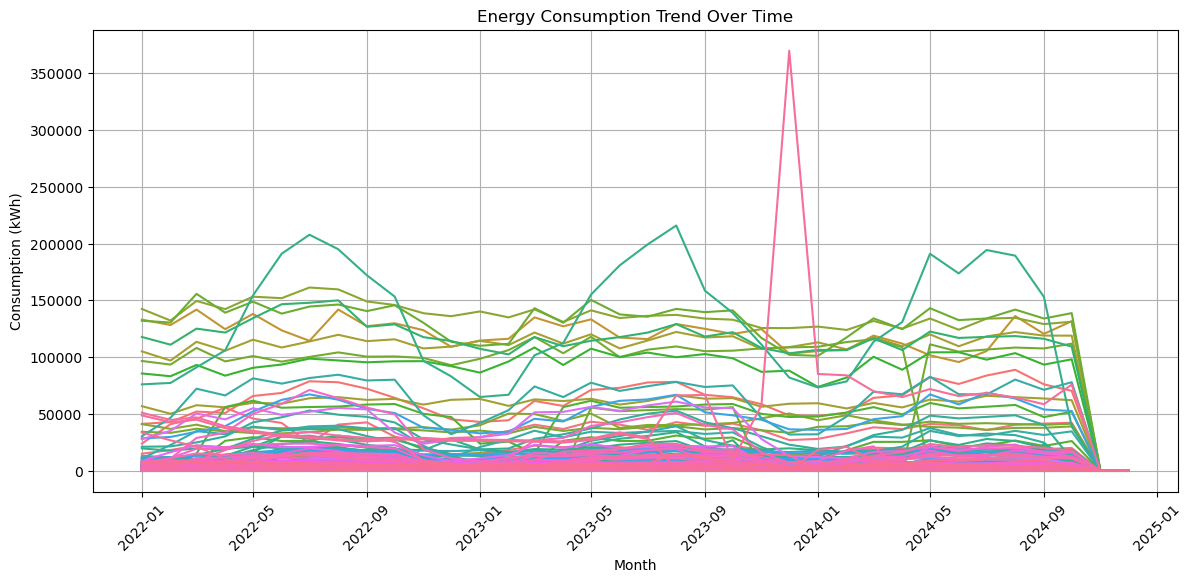

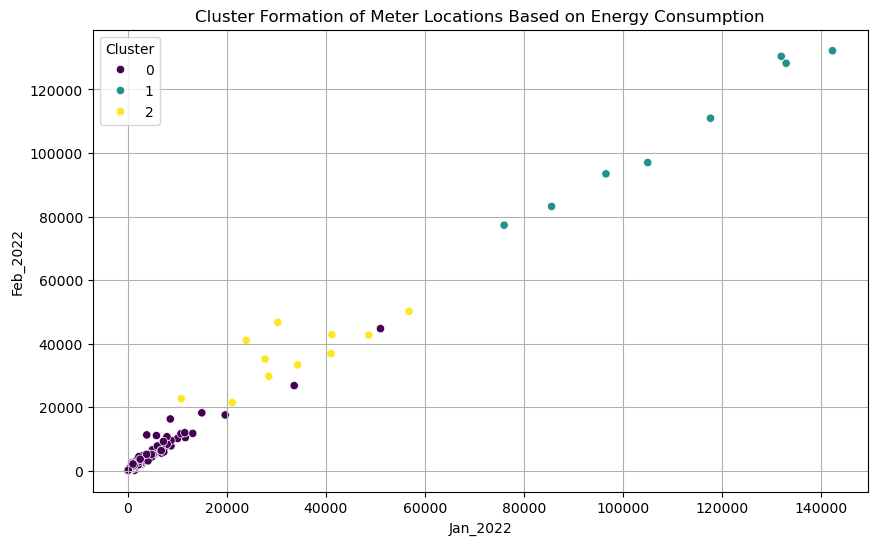

ModuleNotFoundError: No module named 'ace_tools'

In [13]:
# Load the dataset
file_path = "Janitza_UO_F8_X_Cleaned.csv"
df = pd.read_csv(file_path)

# Reshape data for trend analysis
df_melted = df.melt(id_vars=["Meter_location"], var_name="Month", value_name="Consumption")

# Convert month names to datetime format
df_melted["Month"] = pd.to_datetime(df_melted["Month"], format="%b_%Y")

# Plot trend for selected meter locations
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_melted, x="Month", y="Consumption", hue="Meter_location", legend=False)
plt.title("Energy Consumption Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Consumption (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Prepare data for clustering
df_cluster = df.set_index("Meter_location")

# Standardize the data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["Cluster"] = kmeans.fit_predict(df_scaled)

# Visualize cluster formation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x=df_cluster.iloc[:, 0], y=df_cluster.iloc[:, 1], hue=df_cluster["Cluster"], palette="viridis")
plt.title("Cluster Formation of Meter Locations Based on Energy Consumption")
plt.xlabel(df_cluster.columns[0])
plt.ylabel(df_cluster.columns[1])
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Display clustered data
import ace_tools as tools
tools.display_dataframe_to_user(name="Clustered Meter Locations", dataframe=df_cluster)


In [ ]:


# Reshape data for trend analysis
df_melted = df.melt(id_vars=["Meter_location"], var_name="Month", value_name="Consumption")

# Convert month names to datetime format
df_melted["Month"] = pd.to_datetime(df_melted["Month"], format="%b_%Y")

# Plot trend for selected meter locations with labels
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=df_melted, x="Month", y="Consumption", hue="Meter_location", legend=False)

# Annotate some points with meter location names for clarity
selected_meters = df_melted["Meter_location"].unique()[:5]  # Select 5 sample locations
for meter in selected_meters:
    sub_df = df_melted[df_melted["Meter_location"] == meter]
    last_point = sub_df.iloc[-1]  # Get the last data point for labeling
    plt.text(last_point["Month"], last_point["Consumption"], meter, fontsize=9, verticalalignment='top')

plt.title("Energy Consumption Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Consumption (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Calculate the mean consumption for each month across all meters
df_mean = df.drop(columns=["Meter_location"]).mean()

# Convert to DataFrame for plotting
df_mean = pd.DataFrame(df_mean, columns=["Mean_Consumption"])
df_mean.index = pd.to_datetime(df_mean.index, format="%b_%Y")  # Convert index to datetime
df_mean = df_mean.sort_index()  # Ensure chronological order

# Plot the mean energy consumption trend
plt.figure(figsize=(14, 6))
plt.plot(df_mean.index, df_mean["Mean_Consumption"], marker='o', linestyle='-', color='orange', label="Mean Consumption")
plt.title("Mean Energy Consumption Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Mean Consumption (kWh)")
plt.xticks(rotation=45)
plt.grid(True)

# Annotate each data point with its corresponding value
for i, txt in enumerate(df_mean["Mean_Consumption"]):
    plt.annotate(f'{txt:.2f}', (df_mean.index[i], df_mean["Mean_Consumption"][i]), 
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.legend()
plt.show()

# Display the data in tabular form
df_mean_display = df_mean.reset_index().rename(columns={"index": "Month"})

# Show the data
import ace_tools as tools
tools.display_dataframe_to_user(name="Mean Energy Consumption Data", dataframe=df_mean_display)

In [ ]:

# Calculate the mean consumption for each meter location across all months
df_meter_mean = df.set_index("Meter_location").mean(axis=1)

# Convert to DataFrame for plotting
df_meter_mean = pd.DataFrame(df_meter_mean, columns=["Mean_Consumption"])

# Sort the data for better visualization
df_meter_mean = df_meter_mean.sort_values(by="Mean_Consumption", ascending=False)

# Plot the mean consumption for each meter location
plt.figure(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(df_meter_mean)))  # Generate unique colors for each meter location
plt.bar(df_meter_mean.index, df_meter_mean["Mean_Consumption"], color=colors)

# Formatting the plot
plt.xticks(rotation=90, fontsize=8)  # Rotate meter locations for better readability
plt.ylabel("Mean Consumption (kWh)")
plt.xlabel("Meter Location")
plt.title("Mean Energy Consumption Per Meter Location (Jan 2022 - Dec 2024)")
plt.grid(axis="y")

# Show the plot
plt.show()

# Display the mean consumption data for each meter location
import ace_tools as tools
tools.display_dataframe_to_user(name="Mean Consumption Per Meter Location", dataframe=df_meter_mean)


In [ ]:
# Calculate the mean consumption for each meter location across all months
df_meter_mean = df.set_index("Meter_location").mean(axis=1)

# Convert to DataFrame for plotting
df_meter_mean = pd.DataFrame(df_meter_mean, columns=["Mean_Consumption"])

# Sort the data for better visualization
df_meter_mean = df_meter_mean.sort_values(by="Mean_Consumption", ascending=False)

# Define consumption ranges based on quantiles
high_threshold = df_meter_mean["Mean_Consumption"].quantile(0.67)  # Top 33% as high consumption
low_threshold = df_meter_mean["Mean_Consumption"].quantile(0.33)   # Bottom 33% as low consumption

# Split data into three categories
high_consumption = df_meter_mean[df_meter_mean["Mean_Consumption"] >= high_threshold]
medium_consumption = df_meter_mean[(df_meter_mean["Mean_Consumption"] < high_threshold) & 
                                   (df_meter_mean["Mean_Consumption"] >= low_threshold)]
low_consumption = df_meter_mean[df_meter_mean["Mean_Consumption"] < low_threshold]

# Function to plot consumption categories with solid colors
def plot_consumption_solid(data, title, color):
    plt.figure(figsize=(14, 6))
    plt.bar(data.index, data["Mean_Consumption"], color=color)
    
    plt.xticks(rotation=90, fontsize=8)  # Rotate meter locations for better readability
    plt.ylabel("Mean Consumption (kWh)")
    plt.xlabel("Meter Location")
    plt.title(title)
    plt.grid(axis="y")

    plt.show()

# Plot each category separately with solid colors
plot_consumption_solid(high_consumption, "High Energy Consumption Meters", "red")
plot_consumption_solid(medium_consumption, "Medium Energy Consumption Meters", "blue")
plot_consumption_solid(low_consumption, "Low Energy Consumption Meters", "green")

# Display the categorized data tables
import ace_tools as tools
tools.display_dataframe_to_user(name="High Consumption Meters", dataframe=high_consumption)
tools.display_dataframe_to_user(name="Medium Consumption Meters", dataframe=medium_consumption)
tools.display_dataframe_to_user(name="Low Consumption Meters", dataframe=low_consumption)


In [ ]:

# Calculate the mean consumption for each meter location across all months
df_meter_mean = df.set_index("Meter_location").mean(axis=1)
df_meter_mean = pd.DataFrame(df_meter_mean, columns=["Mean_Consumption"])

# 1. **Z-Score Method for Anomaly Detection**
df_meter_mean["Z_Score"] = (df_meter_mean["Mean_Consumption"] - df_meter_mean["Mean_Consumption"].mean()) / df_meter_mean["Mean_Consumption"].std()
df_meter_mean["Z_Anomaly"] = df_meter_mean["Z_Score"].apply(lambda x: "Anomaly" if abs(x) > 3 else "Normal")

# 2. **IQR (Interquartile Range) Method**
Q1 = df_meter_mean["Mean_Consumption"].quantile(0.25)
Q3 = df_meter_mean["Mean_Consumption"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_meter_mean["IQR_Anomaly"] = df_meter_mean["Mean_Consumption"].apply(lambda x: "Anomaly" if x < lower_bound or x > upper_bound else "Normal")

# 3. **Isolation Forest for Anomaly Detection**
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination
df_meter_mean["IsoForest_Anomaly"] = iso_forest.fit_predict(df_meter_mean[["Mean_Consumption"]])
df_meter_mean["IsoForest_Anomaly"] = df_meter_mean["IsoForest_Anomaly"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# 4. **Visualizing Anomalies Using Boxplot**
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_meter_mean["Mean_Consumption"])
plt.title("Boxplot of Mean Energy Consumption with Anomalies")
plt.ylabel("Mean Consumption (kWh)")
plt.grid(True)
plt.show()



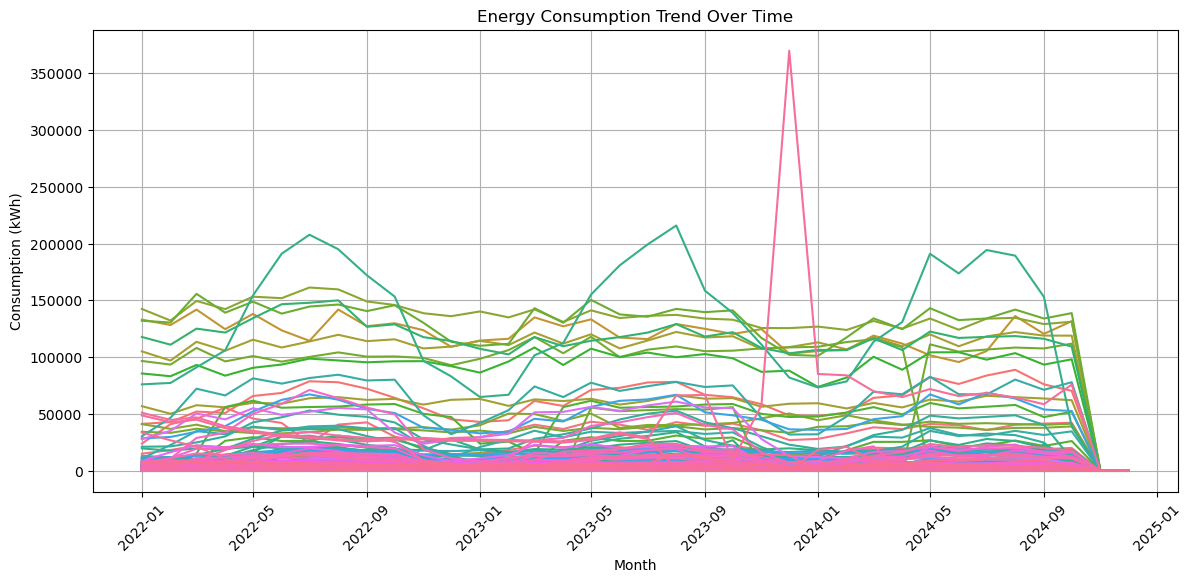

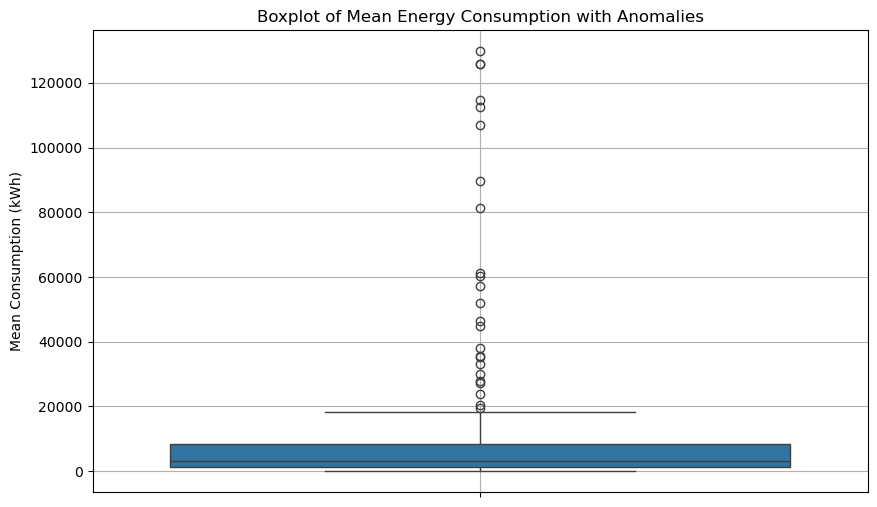

Anomalies saved to 'anomalies_detected.csv'


In [20]:

# Load the dataset
file_path = "Janitza_UO_F8_X_Cleaned.csv"
df = pd.read_csv(file_path)

# Reshape data for trend analysis
df_melted = df.melt(id_vars=["Meter_location"], var_name="Month", value_name="Consumption")
df_melted["Month"] = pd.to_datetime(df_melted["Month"], format="%b_%Y")

# 1. **Energy Consumption Trend Analysis**
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_melted, x="Month", y="Consumption", hue="Meter_location", legend=False)
plt.title("Energy Consumption Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Consumption (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Calculate mean consumption per meter location
df_meter_mean = df.set_index("Meter_location").mean(axis=1)
df_meter_mean = pd.DataFrame(df_meter_mean, columns=["Mean_Consumption"])

# 2. **Anomaly Detection**
# a. Z-Score Method
df_meter_mean["Z_Score"] = (df_meter_mean["Mean_Consumption"] - df_meter_mean["Mean_Consumption"].mean()) / df_meter_mean["Mean_Consumption"].std()
df_meter_mean["Z_Anomaly"] = df_meter_mean["Z_Score"].apply(lambda x: "Anomaly" if abs(x) > 3 else "Normal")

# b. IQR Method
Q1 = df_meter_mean["Mean_Consumption"].quantile(0.25)
Q3 = df_meter_mean["Mean_Consumption"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_meter_mean["IQR_Anomaly"] = df_meter_mean["Mean_Consumption"].apply(lambda x: "Anomaly" if x < lower_bound or x > upper_bound else "Normal")

# c. Isolation Forest Method
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_meter_mean["IsoForest_Anomaly"] = iso_forest.fit_predict(df_meter_mean[["Mean_Consumption"]])
df_meter_mean["IsoForest_Anomaly"] = df_meter_mean["IsoForest_Anomaly"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# Visualize anomalies using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_meter_mean["Mean_Consumption"])
plt.title("Boxplot of Mean Energy Consumption with Anomalies")
plt.ylabel("Mean Consumption (kWh)")
plt.grid(True)
plt.show()

# Extract detected anomalies
anomalies = df_meter_mean[(df_meter_mean["Z_Anomaly"] == "Anomaly") | 
                          (df_meter_mean["IQR_Anomaly"] == "Anomaly") | 
                          (df_meter_mean["IsoForest_Anomaly"] == "Anomaly")]

# Save anomalies to a CSV file
anomalies.to_csv("anomalies_detected.csv")
print("Anomalies saved to 'anomalies_detected.csv'")
# 3. **Clustering Analysis (K-Means)**
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_meter_mean[["Mean_Consumption"]])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_meter_mean["Cluster"] = kmeans.fit_predict(df_scaled)




In [18]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_meter_mean, x=df_meter_mean.index, y=df_meter_mean["Mean_Consumption"], hue=df_meter_mean["Cluster"], palette="viridis")
plt.title("Cluster Formation of Meter Locations Based on Energy Consumption")
plt.xlabel("Meter Location")
plt.ylabel("Mean Consumption (kWh)")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Save clustered data
df_meter_mean.to_csv("clustered_meter_data.csv")
print("Clustered data saved to 'clustered_meter_data.csv'")


NameError: name 'df_meter_mean' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Extract and display the detected anomalies
anomalies = df_meter_mean[(df_meter_mean["Z_Anomaly"] == "Anomaly") | 
                          (df_meter_mean["IQR_Anomaly"] == "Anomaly") | 
                          (df_meter_mean["IsoForest_Anomaly"] == "Anomaly")]

# Display the first few anomalies
print("Detected Anomalies:")
print(anomalies.head())

# Save anomalies to a CSV file for further review
anomalies.to_csv("anomalies_detected.csv", index=True)
print("Anomalies saved to 'anomalies_detected.csv'")


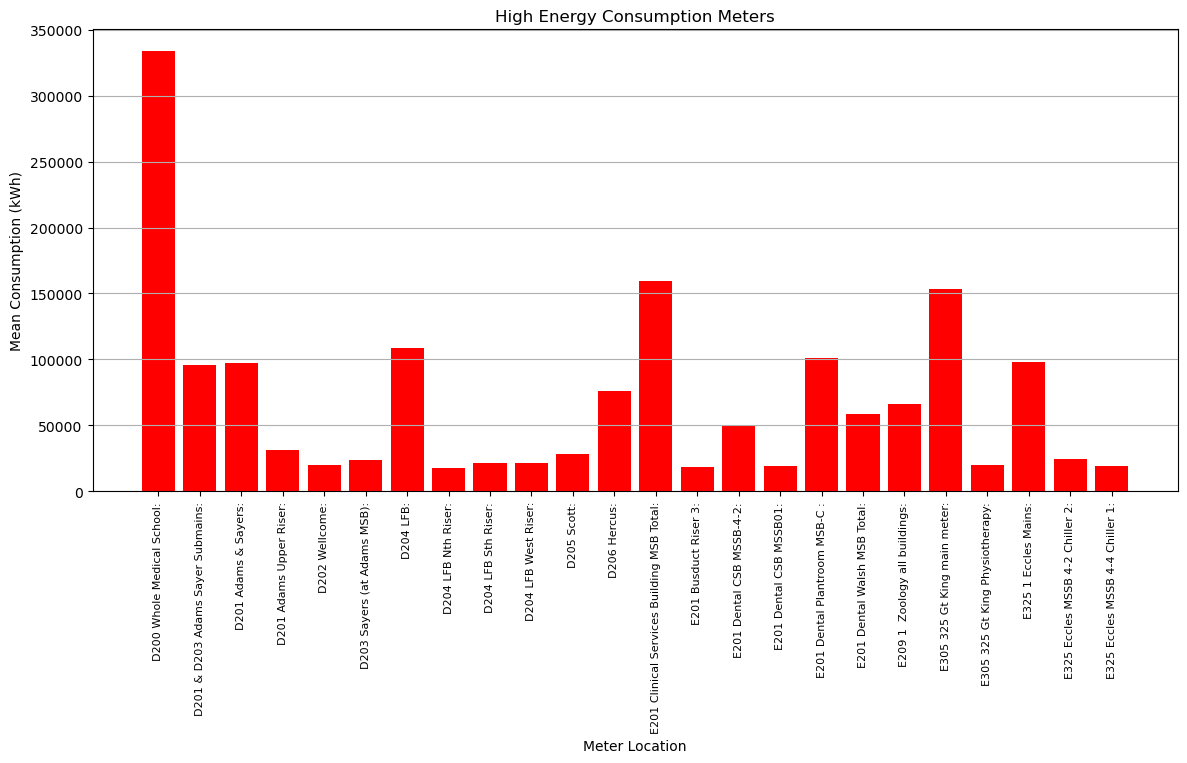

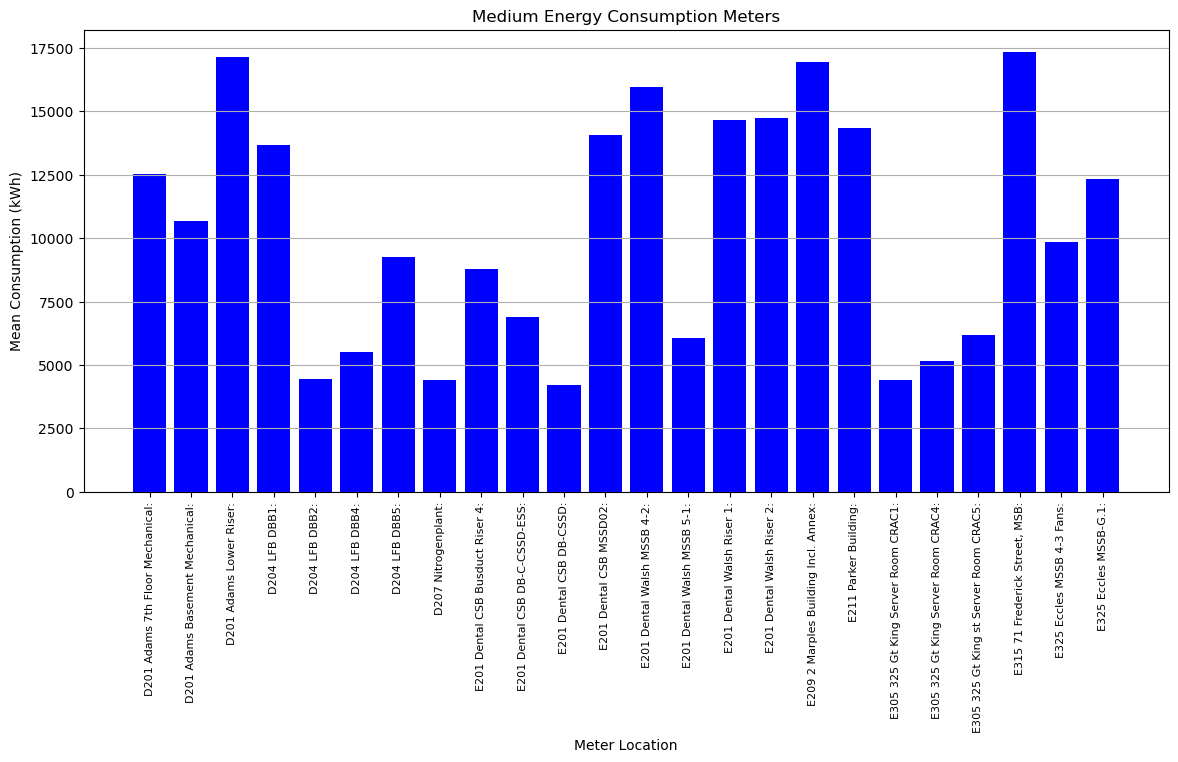

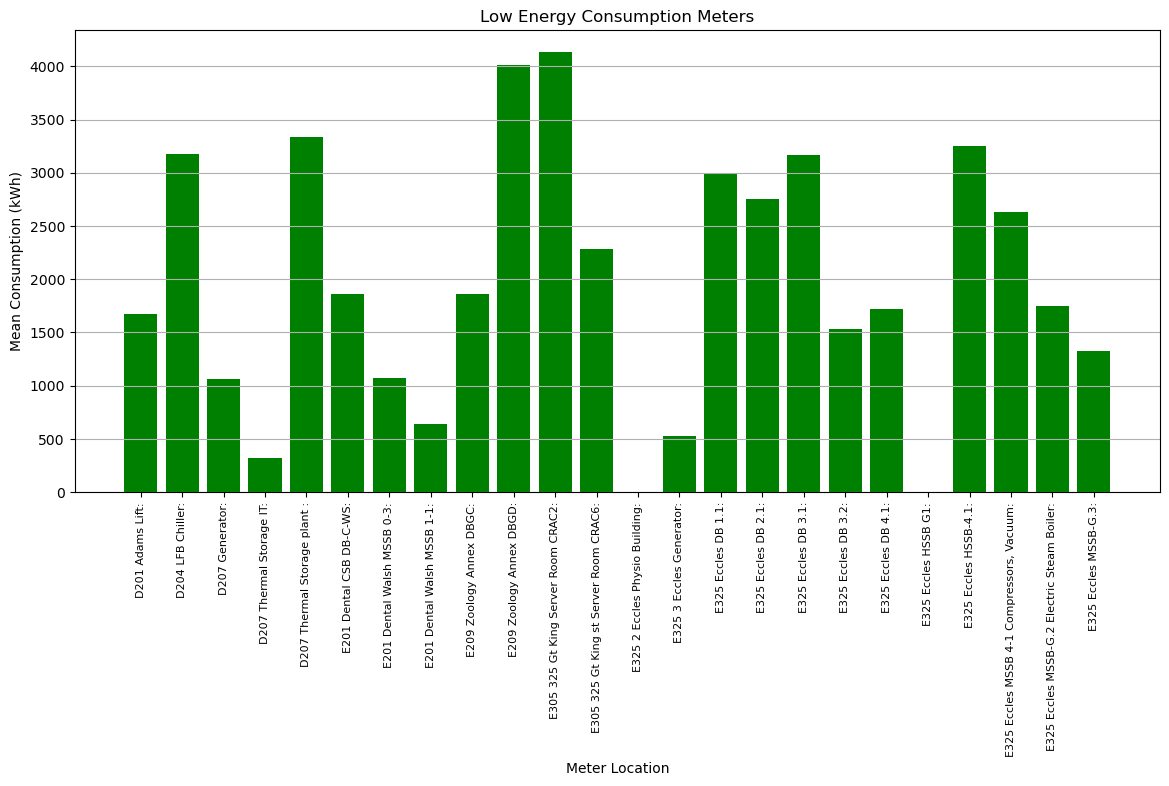

High, Medium, and Low consumption data saved as CSV files.


ModuleNotFoundError: No module named 'ace_tools'

In [28]:

# Calculate the mean consumption for each meter location across all months
df_meter_mean = df.set_index("Meter_location").mean(axis=1)
df_meter_mean = pd.DataFrame(df_meter_mean, columns=["Mean_Consumption"])

# Define consumption ranges based on quantiles
high_threshold = df_meter_mean["Mean_Consumption"].quantile(0.67)  # Top 33% as high consumption
low_threshold = df_meter_mean["Mean_Consumption"].quantile(0.33)   # Bottom 33% as low consumption

# Split data into three categories
high_consumption = df_meter_mean[df_meter_mean["Mean_Consumption"] >= high_threshold]
medium_consumption = df_meter_mean[(df_meter_mean["Mean_Consumption"] < high_threshold) & 
                                   (df_meter_mean["Mean_Consumption"] >= low_threshold)]
low_consumption = df_meter_mean[df_meter_mean["Mean_Consumption"] < low_threshold]

# Function to plot consumption categories with solid colors
def plot_consumption_solid(data, title, color):
    plt.figure(figsize=(14, 6))
    plt.bar(data.index, data["Mean_Consumption"], color=color)
    
    plt.xticks(rotation=90, fontsize=8)  # Rotate meter locations for better readability
    plt.ylabel("Mean Consumption (kWh)")
    plt.xlabel("Meter Location")
    plt.title(title)
    plt.grid(axis="y")

    plt.show()

# Plot each category separately with solid colors
plot_consumption_solid(high_consumption, "High Energy Consumption Meters", "red")
plot_consumption_solid(medium_consumption, "Medium Energy Consumption Meters", "blue")
plot_consumption_solid(low_consumption, "Low Energy Consumption Meters", "green")

# Save categorized data for further analysis
high_consumption.to_csv("high_consumption_meters.csv")
medium_consumption.to_csv("medium_consumption_meters.csv")
low_consumption.to_csv("low_consumption_meters.csv")

print("High, Medium, and Low consumption data saved as CSV files.")

# Display the categorized data
import ace_tools as tools
tools.display_dataframe_to_user(name="High Consumption Meters", dataframe=high_consumption)
tools.display_dataframe_to_user(name="Medium Consumption Meters", dataframe=medium_consumption)
tools.display_dataframe_to_user(name="Low Consumption Meters", dataframe=low_consumption)
